<div style="background-color:#5e548e; padding:10px; border-radius:5px;">
    <b>27March2025</b><br><br>
    <b>OW, KB</b><br><br>
    Predicting a continuous variable - cortical depth<br><br>
    Merging OW [get data and example model] and MF [atlas acronym / id and depth function] codes
</div>

<div style="background-color:#277da1; padding:10px; border-radius:5px;">
    <b>Import and load data</b><br><br>
    Described here: <a href="https://github.com/int-brain-lab/paper-ephys-atlas/" target="_blank">GitHub Repository</a>
</div>


In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
from one.api import ONE
import ephys_atlas.data

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np

import sklearn.metrics
from xgboost import XGBClassifier  # pip install xgboost  # https://xgboost.readthedocs.io/en/stable/prediction.html

from iblutil.numerical import ismember
import ephys_atlas.encoding
import ephys_atlas.decoding
import ephys_atlas.anatomy
import ephys_atlas.data
import ephys_atlas.features

In [6]:
LOCAL_DATA_PATH = Path.home().joinpath("Downloads")
LABEL = "2024_W50"  # or put "latest" # or '2024_W50'
one = ONE(base_url="https://alyx.internationalbrainlab.org", mode='local')
df_raw_features, df_clusters, df_channels, df_probes = ephys_atlas.data.download_tables(label=LABEL, local_path=LOCAL_DATA_PATH, one=one)

In [7]:
df_channels


x         y         z  \
pid                                  channel                                 
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -0.000614 -0.003250 -0.003389   
                                     1       -0.000614 -0.003250 -0.003389   
                                     2       -0.000614 -0.003250 -0.003368   
                                     3       -0.000614 -0.003250 -0.003368   
                                     4       -0.000614 -0.003250 -0.003347   
...                                                ...       ...       ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      0.001373 -0.006825 -0.002962   
                                     380      0.001377 -0.006825 -0.002942   
                                     381      0.001377 -0.006825 -0.002942   
                                     382      0.001382 -0.006825 -0.002923   
                                     383      0.001382 -0.006825 -0.002923   

                                             acronym  atlas_id  axial_um  \
pid                                  channel                               
00a824c0-e060-495f-9ebc-79c82fef4c67 0           MRN       128      20.0   
                                     1           MRN       128      20.0   
                                     2           MRN       128      40.0   
                                     3           MRN       128      40.0   
                                     4           MRN       128      60.0   
...                                              ...       ...       ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379         PRM      1025    3800.0   
                                     380         PRM      1025    3820.0   
                                     381         PRM      1025    3820.0   
                                     382         PRM      1025    3840.0   
                                     383         PRM      1025    3840.0   

                                              lateral_um  x_target  y_target  \
pid                                  channel                                   
00a824c0-e060-495f-9ebc-79c82fef4c67 0              43.0 -0.000352 -0.002844   
                                     1              11.0 -0.000352 -0.002844   
                                     2              59.0 -0.000357 -0.002844   
                                     3              27.0 -0.000357 -0.002844   
                                     4              43.0 -0.000362 -0.002844   
...                                                  ...       ...       ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379            27.0  0.001347 -0.006209   
                                     380            43.0  0.001350 -0.006209   
                                     381            11.0  0.001350 -0.006209   
                                     382            59.0  0.001353 -0.006209   
                                     383            27.0  0.001353 -0.006209   

                                              z_target  atlas_id_target  
pid                                  channel                             
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -0.003299              795  
                                     1       -0.003299              795  
                                     2       -0.003279              795  
                                     3       -0.003279              795  
                                     4       -0.003260              795  
...                                                ...              ...  
ffb1b072-2de7-44a4-8115-5799b9866382 379     -0.003445              512  
                                     380     -0.003426              512  
                                     381     -0.003426              512  
                                     382     -0.003406              512  
                                     383     -0.003406              512  

[384768 rows x 11 columns]

In [8]:
# Here we prepare the dataframe by selecting only the records in isocortex, and computing the cortical depth
from iblatlas.atlas import xyz_to_depth

df_voltage = df_raw_features.merge(df_channels, left_index=True, right_index=True)
aids = brain_atlas.get_labels(df_voltage.loc[:, ['x', 'y', 'z']].values, mode='clip')
df_voltage['Allen_id'] = aids
df_voltage['Cosmos_id'] = brain_atlas.regions.remap(aids, 'Allen', 'Cosmos')

# Collect the xyz coordinates into a full 2D array
# Pass the entire array to xyz_to_depth
df_voltage['cortical_depths']  = xyz_to_depth(df_voltage[['x', 'y', 'z']].to_numpy())
df_voltage = df_voltage.dropna().copy()

print(df_voltage.dropna().shape)


NameError: name 'brain_atlas' is not defined

In [129]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from iblatlas.atlas import BrainRegions
import ephys_atlas.data
import ephys_atlas.features
import ephys_atlas.encoding

""" 
pick only the cortex 
calculate the depths 
"""




x_list = ephys_atlas.features.voltage_features_set(features_list= ['raw_ap', 'raw_lf', 'raw_lf_csd', 'waveforms'])
X = df_voltage.loc[:, x_list].values
scaler = StandardScaler()
scaler.fit(X)
stratify = df_voltage.index.get_level_values("pid").to_numpy()
Y = df_voltage['cortical_depths'].to_numpy()

train_idx, test_idx = ephys_atlas.encoding.train_test_split_indices(df_voltage)
X_test, y_test = (scaler.transform(X[test_idx, :]), Y[test_idx])
X_train, y_train = (scaler.transform(X[train_idx, :]), Y[train_idx])

# print(scaler.transform(X).shape)
# print(df_voltage['cortical_depths'].to_numpy().shape)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaler.transform(X), Y, stratify=stratify, random_state=875, test_size=0.4,
# )


In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 3. Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.1677
Mean Squared Error: 104011.0847


In [133]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.1828
Mean Squared Error: 102125.8623


In [134]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.2466
Mean Squared Error: 94152.4069


In [135]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

KeyboardInterrupt: 

In [136]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')  # or 'linear', 'poly'
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

R² score: 0.2195
Mean Squared Error: 97538.0053


In [137]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor
)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


# 3. Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor()
}

# 4. Fit & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: R² = {r2:.4f}, MSE = {mse:.4f}")

LinearRegression: R² = 0.1677, MSE = 104011.0847
Ridge: R² = 0.1678, MSE = 103999.9100


/mnt/h0/kb/code_kcenia/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.320e+08, tolerance: 2.079e+05
  model = cd_fast.enet_coordinate_descent(


Lasso: R² = 0.1676, MSE = 104020.8521
ElasticNet: R² = 0.1720, MSE = 103471.6780
BayesianRidge: R² = 0.1698, MSE = 103746.9250
HuberRegressor: R² = 0.1696, MSE = 103773.5197


/mnt/h0/kb/code_kcenia/.venv/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
print(f"MLPRegressor: R² = {r2_score(y_test, y_pred):.4f}, MSE = {mean_squared_error(y_test, y_pred):.4f}")

MLPRegressor: R² = 0.0265, MSE = 121653.1971


In [ ]:
# def decode(
#         X, 
#         scaler, 
#         aids, 
#         classifier=None, 
#         save_path=None, 
#         stratify=None):
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, aids, stratify=stratify, random_state=875
#     )
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
#     clf = classifier.fit(X_train, y_train)
#     score_model = clf.score(X_test, y_test)
#     y_null = aids[np.random.randint(0, aids.size - 1, y_test.size)]
#     score_null = clf.score(X_test, y_null)
#     return clf, score_model, score_null


# cclas, cs, csn = decode(
#     X,
#     scaler,
#     aids_cosmos,
#     classifier=RandomForestClassifier(verbose=True, **kwargs),
#     stratify=stratify,
# )

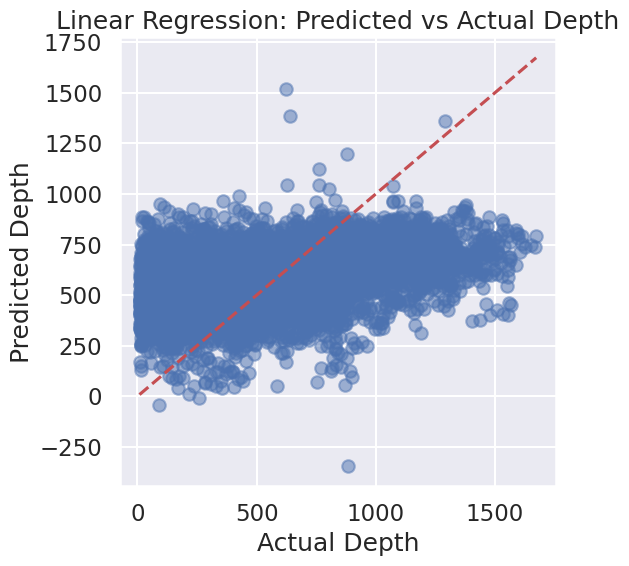

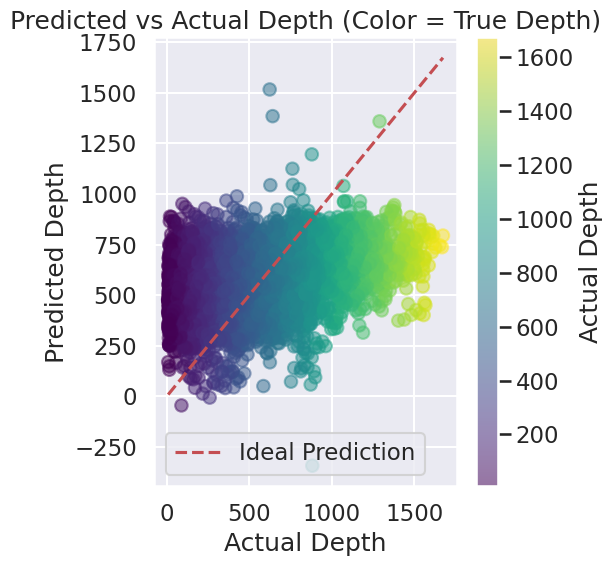

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.title('Linear Regression: Predicted vs Actual Depth')
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
scatter = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')

plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.title('Predicted vs Actual Depth (Color = True Depth)')
plt.colorbar(scatter, label='Actual Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# def decode(
#         X, 
#         scaler, 
#         aids, 
#         classifier=None, 
#         save_path=None, 
#         stratify=None):
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, aids, stratify=stratify, random_state=875
#     )
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
#     clf = classifier.fit(X_train, y_train)
#     score_model = clf.score(X_test, y_test)
#     y_null = aids[np.random.randint(0, aids.size - 1, y_test.size)]
#     score_null = clf.score(X_test, y_null)
#     return clf, score_model, score_null


# cclas, cs, csn = decode(
#     X,
#     scaler,
#     aids_cosmos,
#     classifier=RandomForestClassifier(verbose=True, **kwargs),
#     stratify=stratify,
# )

In [ ]:

kwargs = {
    "n_estimators": 30,
    "max_depth": 25,
    "max_leaf_nodes": 10000,
    "random_state": 420,
}

0.40835544456583944 0.1026273346860205 0.5628011029603038 0.12283439987513657


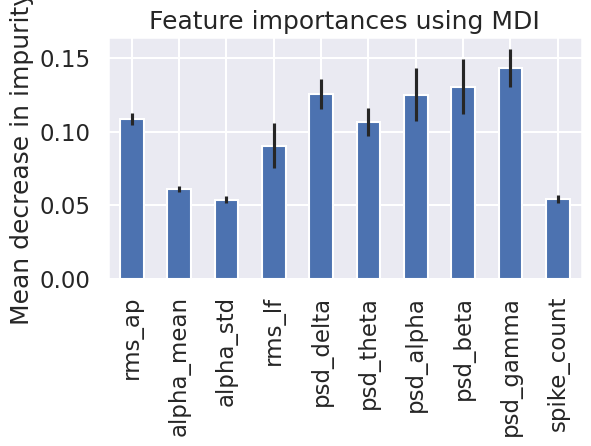

In [39]:

def decode(X, scaler, aids, classifier=None, save_path=None, stratify=None):
    X_train, X_test, y_train, y_test = train_test_split(
        X, aids, stratify=stratify, random_state=875
    )
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    clf = classifier.fit(X_train, y_train)
    score_model = clf.score(X_test, y_test)
    y_null = aids[np.random.randint(0, aids.size - 1, y_test.size)]
    score_null = clf.score(X_test, y_null)
    return clf, score_model, score_null


# cclas, cs, csn = decode(
#     X,
#     scaler,
#     aids_cosmos,
#     classifier=RandomForestClassifier(verbose=True, **kwargs),
#     stratify=stratify,
# )
# bclas, bs, bsn = decode(
#     X,
#     scaler,
#     aids_beryl,
#     classifier=RandomForestClassifier(verbose=True, **kwargs),
#     stratify=stratify,
# )
# print(bs, bsn, cs, csn)
# #
# sns.set_theme(context="talk")
# # forest_importances = pd.Series(cclas.feature_importances_, index=x_list)
# # std = np.std([tree.feature_importances_ for tree in cclas.estimators_], axis=0)
# forest_importances = pd.Series(bclas.feature_importances_, index=x_list)
# std = np.std([tree.feature_importances_ for tree in bclas.estimators_], axis=0)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

#3m12s

In [43]:
##
# auto-encoder or contrastive learning
# take your learned features and model spikes
# phase / frequency / amplitude
accuracy_score(df_voltage["atlas_id"], df_voltage["atlas_id_planned"])  # 0.12
accuracy_score(
    df_voltage["beryl_id"],
    regions.remap(
        df_voltage["atlas_id_planned"], source_map="Allen", target_map="Beryl"
    ),
)  # 0.19 - 0.91
accuracy_score(
    df_voltage["cosmos_id"],
    regions.remap(
        df_voltage["atlas_id_planned"], source_map="Allen", target_map="Cosmos"
    ),
)  # 0.44 - 0.95 

KeyError: 'atlas_id_planned'

In [45]:
stratify

Index(['0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       '0a45a464-a909-4b7c-a3e0-cd6cfb4262e4',
       ...
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382',
       'ffb1b072-2de7-44a4-8115-5799b9866382'],
      dtype='object', name='pid', length=384418)

In [48]:
df_voltage.columns

Index(['alpha_mean', 'alpha_std', 'spike_count', 'peak_time_secs', 'peak_val',
       'trough_time_secs', 'trough_val', 'tip_time_secs', 'tip_val',
       'recovery_time_secs', 'depolarisation_slope', 'repolarisation_slope',
       'recovery_slope', 'polarity', 'rms_ap', 'rms_lf', 'psd_delta',
       'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma', 'psd_lfp',
       'rms_lf_csd', 'psd_delta_csd', 'psd_theta_csd', 'psd_alpha_csd',
       'psd_beta_csd', 'psd_gamma_csd', 'psd_lfp_csd', 'x', 'y', 'z',
       'acronym', 'atlas_id', 'axial_um', 'lateral_um', 'histology', 'version',
       'x_target', 'y_target', 'z_target', 'atlas_id_target', 'beryl_id',
       'cosmos_id'],
      dtype='object')

In [61]:
df_voltage_cosmos = df_voltage[df_voltage['cosmos_id'] == 315]

In [ ]:
""" 
this code cell is only to test examples from the code above and below 
"""

(df_voltage_cosmos_isocortex[[
    'x', 'y', 'z',
    'acronym', 'atlas_id', 'axial_um', 'lateral_um', 'histology', 'version', 'atlas_id_target', 'beryl_id',
    'cosmos_id', 'depths', 'depths_norm'
]])


x         y         z  \
pid                                  channel                                 
0a85a28b-e9e3-44ec-ad4d-88ba9116ff63 296     -0.001338 -0.000766 -0.001455   
                                     298     -0.001355 -0.000764 -0.001444   
                                     300     -0.001372 -0.000762 -0.001434   
                                     302     -0.001388 -0.000761 -0.001423   
                                     304     -0.001405 -0.000759 -0.001412   
...                                                ...       ...       ...   
ff5fceaf-8247-42ab-a187-f7876441899d 372     -0.001314  0.003249 -0.002295   
                                     374     -0.001314  0.003249 -0.002275   
                                     376     -0.001314  0.003249 -0.002255   
                                     380     -0.001314  0.003249 -0.002216   
                                     382     -0.001314  0.003249 -0.002196   

                                               acronym  atlas_id  axial_um  \
pid                                  channel                                 
0a85a28b-e9e3-44ec-ad4d-88ba9116ff63 296      SSp-ll6b     510.0    2980.0   
                                     298      SSp-ll6b     510.0    3000.0   
                                     300      SSp-ll6a     478.0    3020.0   
                                     302      SSp-ll6a     478.0    3040.0   
                                     304      SSp-ll6a     478.0    3060.0   
...                                                ...       ...       ...   
ff5fceaf-8247-42ab-a187-f7876441899d 372        FRP2/3     667.0    3740.0   
                                     374        FRP2/3     667.0    3760.0   
                                     376        FRP2/3     667.0    3780.0   
                                     380        FRP2/3     667.0    3820.0   
                                     382        FRP2/3     667.0    3840.0   

                                              lateral_um histology  \
pid                                  channel                         
0a85a28b-e9e3-44ec-ad4d-88ba9116ff63 296            43.0       alf   
                                     298            59.0       alf   
                                     300            43.0       alf   
                                     302            59.0       alf   
                                     304            43.0       alf   
...                                                  ...       ...   
ff5fceaf-8247-42ab-a187-f7876441899d 372            43.0       alf   
                                     374            59.0       alf   
                                     376            43.0       alf   
                                     380            43.0       alf   
                                     382            59.0       alf   

                                                                   version  \
pid                                  channel                                 
0a85a28b-e9e3-44ec-ad4d-88ba9116ff63 296      patched_pykilosort_ibl_1.3.3   
                                     298      patched_pykilosort_ibl_1.3.3   
                                     300      patched_pykilosort_ibl_1.3.3   
                                     302      patched_pykilosort_ibl_1.3.3   
                                     304      patched_pykilosort_ibl_1.3.3   
...                                                                    ...   
ff5fceaf-8247-42ab-a187-f7876441899d 372              pykilosort_ibl_1.3.0   
                                     374              pykilosort_ibl_1.3.0   
                                     376              pykilosort_ibl_1.3.0   
                                     380              pykilosort_ibl_1.3.0   
                                     382              pykilosort_ibl_1.3.0   

                                              x_target  y_target  z_target  \
pid                

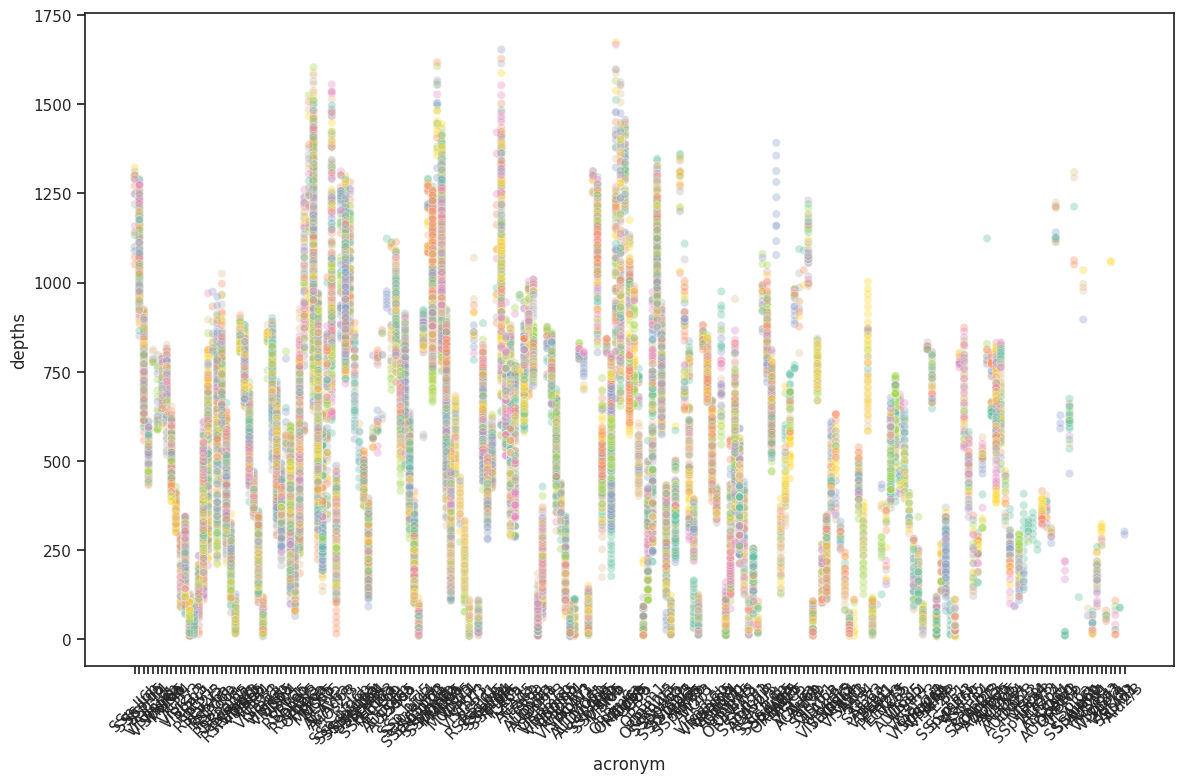

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot style
sns.set(style="ticks", rc={"figure.figsize": (12, 8)})

# Scatterplot without legend
sns.scatterplot(
    data=df_voltage_cosmos_isocortex,
    x='acronym',
    y='depths',
    hue='y',
    palette='Set2',
    s=35,
    alpha=0.35,
    legend=False
)

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



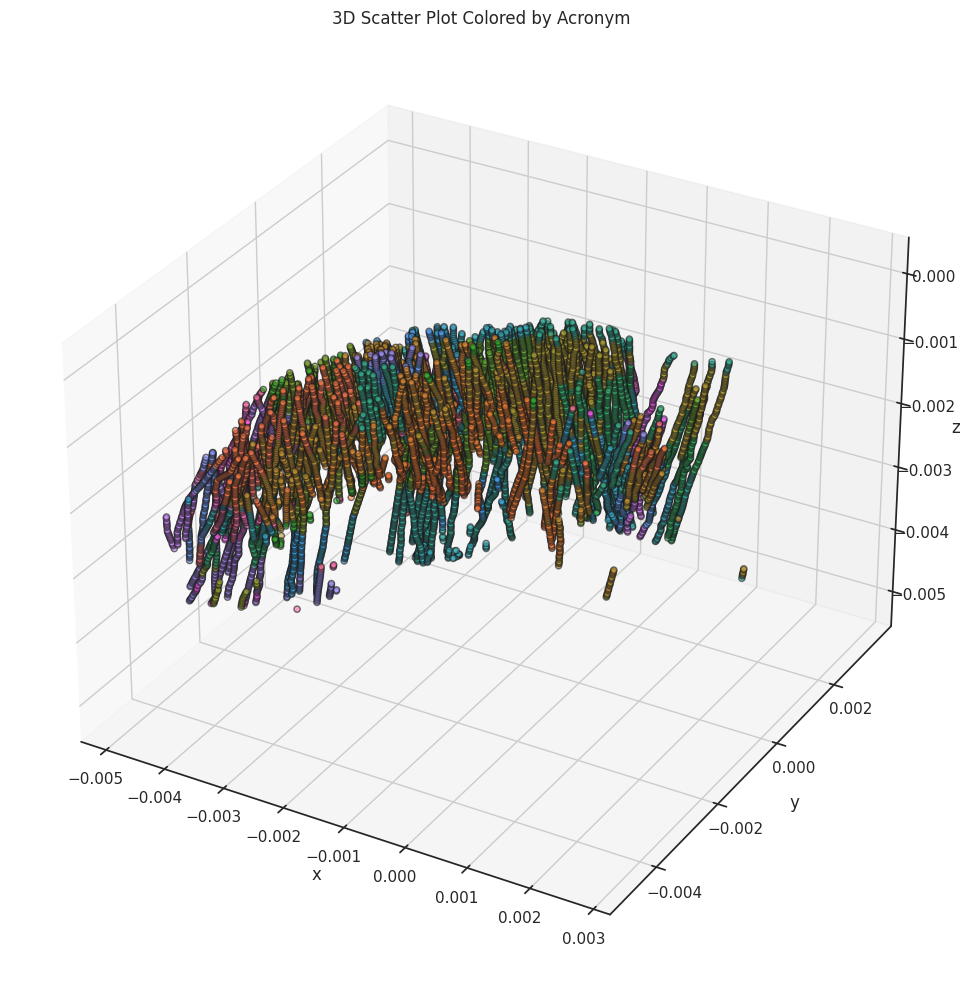

In [177]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
import seaborn as sns
import pandas as pd

# Set up color palette
unique_acronyms = df_voltage_cosmos_isocortex['acronym'].unique()
palette = sns.color_palette("husl", len(unique_acronyms))  # husl gives good spacing
color_map = dict(zip(unique_acronyms, palette))

# Assign a color to each row based on its acronym
df_voltage_cosmos_isocortex['color'] = df_voltage_cosmos_isocortex['acronym'].map(color_map)

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_voltage_cosmos_isocortex['x'],
    df_voltage_cosmos_isocortex['y'],
    df_voltage_cosmos_isocortex['z'],
    c=df_voltage_cosmos_isocortex['color'],
    s=20,
    alpha=0.6,
    edgecolor='k'
)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Scatter Plot Colored by Acronym')

plt.tight_layout()
plt.show()


In [191]:
import plotly.express as px
fig = plt.figure(figsize=(12, 12))
fig = px.scatter_3d(
    df_voltage_cosmos_isocortex,
    x='x',
    y='y',
    z='depths',
    color='z',               # hue
    hover_data=['z'],        # info on hover
    opacity=0.3
)

fig.update_traces(marker=dict(size=3))  # smaller points
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='Interactive 3D Plot: x, y, z colored by Acronym',
    margin=dict(l=0, r=0, b=0, t=40)  # tight margins
)

fig.show()


<Figure size 1200x1200 with 0 Axes>

In [2]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from brainbox.plot_base import (ImagePlot, ScatterPlot, ProbePlot, LinePlot, plot_line,
                                plot_image, plot_probe, plot_scatter, arrange_channels2banks)
from brainbox.processing import compute_cluster_average
from iblutil.numerical import bincount2D
from iblatlas.regions import BrainRegions


def image_lfp_spectrum_plot(lfp_power, lfp_freq, chn_coords=None, chn_inds=None, freq_range=(0, 300),
                            avg_across_depth=False, clim=None, cmap='viridis', display=False, title=None, **kwargs):
    """
    Prepare data for 2D image plot of LFP power spectrum along depth of probe

    :param lfp_power:
    :param lfp_freq:
    :param chn_depths:
    :param chn_inds:
    :param freq_range:
    :param avg_across_depth: Whether to average across channels at same depth
    :param cmap:
    :param display: generate figure
    :return: ImagePlot object, if display=True also returns matplotlib fig and ax objects
    """

    ylabel = 'Channel index' if chn_coords is None else 'Distance from probe tip (um)'
    title = title or 'LFP Power Spectrum'

    y = np.arange(lfp_power.shape[1]) if chn_coords is None else chn_coords[:, 1]
    chn_inds = np.arange(lfp_power.shape[1]) if chn_inds is None else chn_inds

    freq_idx = np.where((lfp_freq >= freq_range[0]) & (lfp_freq < freq_range[1]))[0]
    freqs = lfp_freq[freq_idx]
    lfp = np.take(lfp_power[freq_idx], chn_inds, axis=1)
    lfp_db = 10 * np.log10(lfp)
    lfp_db[np.isinf(lfp_db)] = np.nan
    x = freqs

    # Average across channels that are at the same depth
    if avg_across_depth:
        chn_depth, chn_idx, chn_count = np.unique(y, return_index=True,
                                                  return_counts=True)
        chn_idx_eq = np.copy(chn_idx)
        chn_idx_eq[np.where(chn_count == 2)] += 1

        lfp_db = np.apply_along_axis(lambda a: np.mean([a[chn_idx], a[chn_idx_eq]], axis=0), 1,
                                     lfp_db)

        x = freqs
        y = chn_depth

    data = ImagePlot(lfp_db, x=x, y=y, cmap=cmap)
    data.set_labels(title=title, xlabel='Frequency (Hz)',
                    ylabel=ylabel, clabel='LFP Power (dB)')
    clim = clim or np.quantile(lfp_db, [0.1, 0.9])
    data.set_clim(clim=clim)

    if display:
        ax, fig = plot_image(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def image_rms_plot(rms_amps, rms_times, chn_coords=None, chn_inds=None, avg_across_depth=False,
                   median_subtract=True, clim=None, cmap='plasma', band='AP', display=False, title=None, **kwargs):
    """
    Prepare data for 2D image plot of RMS data along depth of probe

    :param rms_amps:
    :param rms_times:
    :param chn_coords:
    :param chn_inds:
    :param avg_across_depth: Whether to average across channels at same depth
    :param median_subtract: Whether to apply median subtraction correction
    :param cmap:
    :param band: Frequency band of rms data, can be either 'LF' or 'AP'
    :param display: generate figure
    :return: ImagePlot object, if display=True also returns matplotlib fig and ax objects
    """

    ylabel = 'Channel index' if chn_coords is None else 'Distance from probe tip (um)'
    title = title or f'{band} RMS'
    chn_inds = np.arange(rms_amps.shape[1]) if chn_inds is None else chn_inds
    y = np.arange(rms_amps.shape[1]) if chn_coords is None else chn_coords[:, 1]

    rms = rms_amps[:, chn_inds]
    rms = 10 * np.log10(rms)
    x = rms_times

    if avg_across_depth:
        chn_depth, chn_idx, chn_count = np.unique(y, return_index=True, return_counts=True)
        chn_idx_eq = np.copy(chn_idx)
        chn_idx_eq[np.where(chn_count == 2)] += 1
        rms = np.apply_along_axis(lambda a: np.mean([a[chn_idx], a[chn_idx_eq]], axis=0), 1, rms)
        y = chn_depth

    if median_subtract:
        median = np.mean(np.apply_along_axis(lambda a: np.median(a), 1, rms))
        rms = np.apply_along_axis(lambda a: a - np.median(a), 1, rms) + median

    data = ImagePlot(rms, x=x, y=y, cmap=cmap)
    data.set_labels(title=title, xlabel='Time (s)', ylabel=ylabel, clabel=f'{band} RMS (dB)')
    clim = clim or np.quantile(rms, [0.1, 0.9])
    data.set_clim(clim=clim)

    if display:
        ax, fig = plot_image(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def scatter_raster_plot(spike_amps, spike_depths, spike_times, n_amp_bins=10, cmap='BuPu',
                        subsample_factor=100, display=False, title=None, **kwargs):
    """
    Prepare data for 2D raster plot of spikes with colour and size indicative of spike amplitude

    :param spike_amps:
    :param spike_depths:
    :param spike_times:
    :param n_amp_bins: no. of colour and size bins into which to split amplitude data
    :param cmap:
    :param subsample_factor: factor by which to subsample data when too many points for efficient
    display
    :param display: generate figure
    :return: ScatterPlot object, if display=True also returns matplotlib fig and ax objects
    """

    title = title or 'Spike times vs Spike depths'
    amp_range = np.quantile(spike_amps, [0, 0.9])
    amp_bins = np.linspace(amp_range[0], amp_range[1], n_amp_bins)
    color_bin = np.linspace(0.0, 1.0, n_amp_bins + 1)
    colors = (cm.get_cmap(cmap)(color_bin)[np.newaxis, :, :3][0])

    spike_amps = spike_amps[0:-1:subsample_factor]
    spike_colors = np.zeros((spike_amps.size, 3))
    spike_size = np.zeros(spike_amps.size)
    for iA in range(amp_bins.size):
        if iA == (amp_bins.size - 1):
            idx = np.where(spike_amps > amp_bins[iA])[0]
            # Make saturated spikes the darkest colour
            spike_colors[idx] = colors[-1]
        else:
            idx = np.where((spike_amps > amp_bins[iA]) & (spike_amps <= amp_bins[iA + 1]))[0]
            spike_colors[idx] = [*colors[iA]]

        spike_size[idx] = iA / (n_amp_bins / 8)

    data = ScatterPlot(x=spike_times[0:-1:subsample_factor], y=spike_depths[0:-1:subsample_factor],
                       c=spike_amps * 1e6, cmap='BuPu')
    data.set_ylim((0, 3840))
    data.set_color(color=spike_colors)
    data.set_clim(clim=amp_range * 1e6)
    data.set_marker_size(marker_size=spike_size)
    data.set_labels(title=title, xlabel='Time (s)',
                    ylabel='Distance from probe tip (um)', clabel='Spike amplitude (uV)')

    if display:
        ax, fig = plot_scatter(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def image_fr_plot(spike_depths, spike_times, chn_coords, t_bin=0.05, d_bin=5, cmap='binary',
                  display=False, title=None, **kwargs):
    """
    Prepare data 2D raster plot of firing rate across recording

    :param spike_depths:
    :param spike_times:
    :param chn_coords:
    :param t_bin: time bin to average across (see also brainbox.processing.bincount2D)
    :param d_bin: depth bin to average across (see also brainbox.processing.bincount2D)
    :param cmap:
    :param display: generate figure
    :return: ImagePlot object, if display=True also returns matplotlib fig and ax objects
    """

    title = title or 'Firing Rate'
    n, x, y = bincount2D(spike_times, spike_depths, t_bin, d_bin,
                         ylim=[0, np.max(chn_coords[:, 1])])
    fr = n.T / t_bin

    data = ImagePlot(fr, x=x, y=y, cmap=cmap)
    data.set_labels(title=title, xlabel='Time (s)',
                    ylabel='Distance from probe tip (um)', clabel='Firing Rate (Hz)')
    data.set_clim(clim=(np.min(np.mean(fr, axis=0)), np.max(np.mean(fr, axis=0))))
    if display:
        ax, fig = plot_image(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def image_crosscorr_plot(spike_depths, spike_times, chn_coords, t_bin=0.05, d_bin=40,
                         cmap='viridis', display=False, title=None, **kwargs):
    """
    Prepare data for 2D cross correlation plot of data across depth

    :param spike_depths:
    :param spike_times:
    :param chn_coords:
    :param t_bin: t_bin: time bin to average across (see also brainbox.processing.bincount2D)
    :param d_bin: depth bin to average across (see also brainbox.processing.bincount2D)
    :param cmap:
    :param display: generate figure
    :return: ImagePlot object, if display=True also returns matploltlib fig and ax objects
    """

    title = title or 'Correlation'
    n, x, y = bincount2D(spike_times, spike_depths, t_bin, d_bin,
                         ylim=[0, np.max(chn_coords[:, 1])])
    corr = np.corrcoef(n)
    corr[np.isnan(corr)] = 0

    data = ImagePlot(corr, x=y, y=y, cmap=cmap)
    data.set_labels(title=title, xlabel='Distance from probe tip (um)',
                    ylabel='Distance from probe tip (um)', clabel='Correlation')

    if display:
        ax, fig = plot_image(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def scatter_amp_depth_fr_plot(spike_amps, spike_clusters, spike_depths, spike_times, cmap='hot',
                              display=False, title=None, **kwargs):
    """
    Prepare data for 2D scatter plot of cluster depth vs cluster amp with colour indicating cluster
    firing rate

    :param spike_amps:
    :param spike_clusters:
    :param spike_depths:
    :param spike_times:
    :param cmap:
    :param display: generate figure
    :return: ScatterPlot object, if display=True also returns matplotlib fig and ax objects
    """

    title = title or 'Cluster depth vs amp vs firing rate'

    # TODO use pandas here instead, much quicker
    cluster, cluster_depth, n_cluster = compute_cluster_average(spike_clusters, spike_depths)
    _, cluster_amp, _ = compute_cluster_average(spike_clusters, spike_amps)
    cluster_amp = cluster_amp * 1e6
    cluster_fr = n_cluster / np.max(spike_times)

    data = ScatterPlot(x=cluster_amp, y=cluster_depth, c=cluster_fr, cmap=cmap)
    data.set_xlim((0.9 * np.min(cluster_amp), 1.1 * np.max(cluster_amp)))
    data.set_labels(title=title, xlabel='Cluster Amplitude (uV)', ylabel='Distance from probe tip (um)',
                    clabel='Firing rate (Hz)')
    if display:
        ax, fig = plot_scatter(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def probe_lfp_spectrum_plot(lfp_power, lfp_freq, chn_coords, chn_inds, freq_range=(0, 4),
                            display=False, pad=True, x_offset=1, **kwargs):
    """
    Prepare data for 2D probe plot of LFP power spectrum along depth of probe

    :param lfp_power:
    :param lfp_freq:
    :param chn_coords:
    :param chn_inds:
    :param freq_range:
    :param display:
    :param pad: whether to add nans around the individual image plots. For matplotlib use pad=True,
    for pyqtgraph use pad=False
    :param x_offset: Distance between the channel banks in x direction
    :return: ProbePlot object, if display=True also returns matplotlib fig and ax objects
    """

    freq_idx = np.where((lfp_freq >= freq_range[0]) & (lfp_freq < freq_range[1]))[0]
    lfp = np.take(lfp_power[freq_idx], chn_inds, axis=1)
    lfp_db = 10 * np.log10(lfp)
    lfp_db[np.isinf(lfp_db)] = np.nan
    lfp_db = np.mean(lfp_db, axis=0)

    data_bank, x_bank, y_bank = arrange_channels2banks(lfp_db, chn_coords, depth=None,
                                                       pad=pad, x_offset=x_offset)
    data = ProbePlot(data_bank, x=x_bank, y=y_bank)
    data.set_labels(ylabel='Distance from probe tip (um)', clabel='PSD 0-4 Hz (dB)')
    clim = np.nanquantile(np.concatenate([np.squeeze(np.ravel(d)) for d in data_bank]).ravel(),
                          [0.1, 0.9])
    data.set_clim(clim)

    if display:
        ax, fig = plot_probe(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def probe_rms_plot(rms_amps, chn_coords, chn_inds, cmap='plasma', band='AP',
                   display=False, pad=True, x_offset=1, **kwargs):
    """
    Prepare data for 2D probe plot of RMS along depth of probe

    :param rms_amps:
    :param chn_coords:
    :param chn_inds:
    :param cmap:
    :param band:
    :param display:
    :param pad: whether to add nans around the individual image plots. For matplotlib use pad=True,
    for pyqtgraph use pad=False
    :param x_offset: Distance between the channel banks in x direction
    :return: ProbePlot object, if display=True also returns matplotlib fig and ax objects
    """

    rms = (np.mean(rms_amps, axis=0)[chn_inds]) * 1e6

    data_bank, x_bank, y_bank = arrange_channels2banks(rms, chn_coords, depth=None,
                                                       pad=pad, x_offset=x_offset)
    data = ProbePlot(data_bank, x=x_bank, y=y_bank, cmap=cmap)
    data.set_labels(ylabel='Distance from probe tip (um)', clabel=f'{band} RMS (uV)')
    clim = np.nanquantile(np.concatenate([np.squeeze(np.ravel(d)) for d in data_bank]).ravel(),
                          [0.1, 0.9])
    data.set_clim(clim)

    if display:
        ax, fig = plot_probe(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def line_fr_plot(spike_depths, spike_times, chn_coords, d_bin=10, display=False, title=None, **kwargs):
    """
    Prepare data for 1D line plot of average firing rate across depth

    :param spike_depths:
    :param spike_times:
    :param chn_coords:
    :param d_bin: depth bin to average across (see also brainbox.processing.bincount2D)
    :param display:
    :return:
    """

    title = title or 'Avg Firing Rate'
    t_bin = np.max(spike_times)
    n, x, y = bincount2D(spike_times, spike_depths, t_bin, d_bin,
                         ylim=[0, np.max(chn_coords[:, 1])])
    mean_fr = n[:, 0] / t_bin

    data = LinePlot(x=mean_fr, y=y)
    data.set_xlim((0, np.max(mean_fr)))
    data.set_labels(title=title, xlabel='Firing Rate (Hz)',
                    ylabel='Distance from probe tip (um)')

    if display:
        ax, fig = plot_line(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


def line_amp_plot(spike_amps, spike_depths, spike_times, chn_coords, d_bin=10, display=False, title=None, **kwargs):
    """
    Prepare data for 1D line plot of average firing rate across depth
    :param spike_amps:
    :param spike_depths:
    :param spike_times:
    :param chn_coords:
    :param d_bin: depth bin to average across (see also brainbox.processing.bincount2D)
    :param display:
    :return:
    """
    title = title or 'Avg Amplitude'
    t_bin = np.max(spike_times)
    n, _, _ = bincount2D(spike_times, spike_depths, t_bin, d_bin,
                         ylim=[0, np.max(chn_coords[:, 1])])
    amp, x, y = bincount2D(spike_times, spike_depths, t_bin, d_bin,
                           ylim=[0, np.max(chn_coords[:, 1])], weights=spike_amps)

    mean_amp = np.divide(amp[:, 0], n[:, 0]) * 1e6
    mean_amp[np.isnan(mean_amp)] = 0
    remove_bins = np.where(n[:, 0] < 50)[0]
    mean_amp[remove_bins] = 0

    data = LinePlot(x=mean_amp, y=y)
    data.set_xlim((0, np.max(mean_amp)))
    data.set_labels(title=title, xlabel='Amplitude (uV)',
                    ylabel='Distance from probe tip (um)')
    if display:
        ax, fig = plot_line(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax
    return data


def plot_brain_regions(channel_ids, channel_depths=None, brain_regions=None, display=True, ax=None,
                       title=None, label='left', **kwargs):
    """
    Plot brain regions along probe, if channel depths is provided will plot along depth otherwise along channel idx
    :param channel_ids: atlas ids for each channel
    :param channel_depths: depth along probe for each channel
    :param brain_regions: BrainRegions object
    :param display: whether to output plot
    :param ax: axis to plot on
    :param title: title for plot
    :param kwargs: additional keyword arguments for bar plot
    :return:
    """

    if channel_depths is not None:
        assert channel_ids.shape[0] == channel_depths.shape[0]
    else:
        channel_depths = np.arange(channel_ids.shape[0])

    br = brain_regions or BrainRegions()

    region_info = br.get(channel_ids)
    boundaries = np.where(np.diff(region_info.id) != 0)[0]
    boundaries = np.r_[0, boundaries, region_info.id.shape[0] - 1]

    regions = np.c_[boundaries[0:-1], boundaries[1:]]
    if channel_depths is not None:
        regions = channel_depths[regions]
    region_labels = np.c_[np.mean(regions, axis=1), region_info.acronym[boundaries[1:]]]
    region_colours = region_info.rgb[boundaries[1:]]

    if display:
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()

        for reg, col in zip(regions, region_colours):
            height = np.abs(reg[1] - reg[0])
            bar_kwargs = dict(edgecolor='w', width=1)
            bar_kwargs.update(**kwargs)
            color = col / 255
            ax.bar(x=0.5, height=height, color=color, bottom=reg[0], **kwargs)
        if label == 'right':
            ax.yaxis.tick_right()
        ax.set_yticks(region_labels[:, 0].astype(int))
        ax.yaxis.set_tick_params(labelsize=8)
        ax.set_ylim(np.nanmin(channel_depths), np.nanmax(channel_depths))
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels(region_labels[:, 1])
        if label == 'right':
            ax.yaxis.tick_right()
            ax.spines['left'].set_visible(False)
        else:
            ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if title:
            ax.set_title(title)

        return fig, ax
    else:
        return regions, region_labels, region_colours


def plot_cdf(spike_amps, spike_depths, spike_times, n_amp_bins=10, d_bin=40, amp_range=None, d_range=None,
             display=False, cmap='hot', ax=None):
    """
    Plot cumulative amplitude of spikes across depth
    :param spike_amps:
    :param spike_depths:
    :param spike_times:
    :param n_amp_bins: number of amplitude bins to use
    :param d_bin: the value of the depth bins in um (default is 40 um)
    :param amp_range: amp range to use [amp_min, amp_max], if not given automatically computed from spike_amps
    :param d_range: depth range to use, by default [0, 3840]
    :param display: whether or not to display plot
    :param cmap:
    :return:
    """

    amp_range = amp_range or np.quantile(spike_amps, (0, 0.9))
    amp_bins = np.linspace(amp_range[0], amp_range[1], n_amp_bins)
    d_range = d_range or [0, 3840]
    depth_bins = np.arange(d_range[0], d_range[1] + d_bin, d_bin)
    t_bin = np.max(spike_times)

    def histc(x, bins):
        map_to_bins = np.digitize(x, bins)  # Get indices of the bins to which each value in input array belongs.
        res = np.zeros(bins.shape)

        for el in map_to_bins:
            res[el - 1] += 1  # Increment appropriate bin.
        return res

    cdfs = np.empty((len(depth_bins) - 1, n_amp_bins))
    for d in range(len(depth_bins) - 1):
        spikes = np.bitwise_and(spike_depths > depth_bins[d], spike_depths <= depth_bins[d + 1])
        h = histc(spike_amps[spikes], amp_bins) / t_bin
        hcsum = np.cumsum(h[::-1])
        cdfs[d, :] = hcsum[::-1]

    cdfs[cdfs == 0] = np.nan

    data = ImagePlot(cdfs.T, x=amp_bins * 1e6, y=depth_bins[:-1], cmap=cmap)
    data.set_labels(title='Cumulative Amplitude', xlabel='Spike amplitude (uV)',
                    ylabel='Distance from probe tip (um)', clabel='Firing Rate (Hz)')

    if display:
        ax, fig = plot_image(data.convert2dict(), fig_kwargs={'figsize': [3, 7]}, ax=ax)
        return data.convert2dict(), fig, ax

    return data


def image_raw_data(raw, fs, chn_coords=None, cmap='bone', title=None, display=False, gain=-90, **kwargs):

    def gain2level(gain):
        return 10 ** (gain / 20) * 4 * np.array([-1, 1])

    ylabel = 'Channel index' if chn_coords is None else 'Distance from probe tip (um)'
    title = title or 'Raw data'

    y = np.arange(raw.shape[1]) if chn_coords is None else chn_coords[:, 1]

    x = np.array([0, raw.shape[0] - 1]) / fs * 1e3

    data = ImagePlot(raw, y=y, cmap=cmap)
    data.set_labels(title=title, xlabel='Time (ms)',
                    ylabel=ylabel, clabel='Power (uV)')
    clim = gain2level(gain)
    data.set_clim(clim=clim)
    data.set_xlim(xlim=x)
    data.set_ylim()

    if display:
        ax, fig = plot_image(data.convert2dict(), **kwargs)
        return data.convert2dict(), fig, ax

    return data


In [3]:
df_voltage_cosmos_isocortex

NameError: name 'df_voltage_cosmos_isocortex' is not defined

In [208]:
df_voltage_cosmos_isocortex.columns

Index(['alpha_mean', 'alpha_std', 'spike_count', 'peak_time_secs', 'peak_val',
       'trough_time_secs', 'trough_val', 'tip_time_secs', 'tip_val',
       'recovery_time_secs', 'depolarisation_slope', 'repolarisation_slope',
       'recovery_slope', 'polarity', 'rms_ap', 'rms_lf', 'psd_delta',
       'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma', 'psd_lfp',
       'rms_lf_csd', 'psd_delta_csd', 'psd_theta_csd', 'psd_alpha_csd',
       'psd_beta_csd', 'psd_gamma_csd', 'psd_lfp_csd', 'x', 'y', 'z',
       'acronym', 'atlas_id', 'axial_um', 'lateral_um', 'histology', 'version',
       'x_target', 'y_target', 'z_target', 'atlas_id_target', 'beryl_id',
       'cosmos_id', 'depths', 'depths_norm', 'color'],
      dtype='object')

In [211]:
depth = df_pid.groupby('depths').agg(atlas_id=pd.NamedAgg(column='atlas_id', aggfunc='first')).reset_index()
depth

depths  atlas_id
0    590.166870    1094.0
1    622.282654    1128.0
2    652.661621    1128.0
3    660.097778    1128.0
4    690.314636    1128.0
5    718.781677    1128.0
6    746.954895    1128.0
7    776.291443    1128.0
8    807.337036    1128.0
9    813.894653    1128.0
10   835.948181    1128.0
11   864.559448    1128.0
12   893.613647    1128.0
13   926.140381     478.0
14   932.708008     478.0
15   958.200439     478.0
16   980.990967     478.0
17   990.476624     478.0
18  1016.219482     478.0
19  1048.781372     478.0
20  1076.740479     478.0
21  1103.255249     478.0
22  1128.785889     478.0
23  1155.347656     478.0
24  1163.095947     478.0
25  1186.102417     478.0
26  1193.138184     478.0
27  1210.699829     478.0
28  1215.062500     478.0
29  1236.304077     478.0
30  1248.906250     510.0
31  1249.091309     510.0

In [218]:
import sys
sys.path.append('/mnt/h0/kb/code_kcenia/ibllib')

from brainbox.ephys_plots import plot_brain_regions, plot_probe
from brainbox.plot_base import arrange_channels2banks, ProbePlot



In [224]:

df_pid[feature_name].values


KeyError: 'depths'

In [225]:
from brainbox.ephys_plots import plot_brain_regions, plot_probe
from brainbox.plot_base import arrange_channels2banks, ProbePlot

for i, pid in enumerate(pids):
    df_pid = df_voltage_cosmos_isocortex.loc[pid]

    depth = df_pid.groupby('axial_um').agg(atlas_id=pd.NamedAgg(column='atlas_id', aggfunc='first')).reset_index()
    plot_brain_regions(depth['atlas_id'].values,
                       channel_depths=depth['axial_um'].values,
                       brain_regions=regions, display=True, ax=ax[i * 3])

    ax[-2].plot(df_pid['x'].values * 1e6, df_pid['y'].values * 1e6, '.', color='r', markersize=2)
    ax[-2].plot(df_pid['x'].values[-1] * 1e6, df_pid['y'].values[-1] * 1e6, '*', color='k', markersize=2)
    ax[i * 3 + 2].axis('off')

    feature = df_pid[feature_name].values
    if feature_name in transform:
        feature = transform[feature_name](feature)

    data_bank, x_bank, y_bank = arrange_channels2banks(
        data=feature,
        chn_coords=df_pid[['lateral_um', 'axial_um']].values,
        pad=True,
    )

    data = ProbePlot(data_bank, x=x_bank, y=y_bank, cmap=colormap)
    data.clim = clim
    plot_probe(data.convert2dict(), ax=ax[i * 3 + 1], show_cbar=False)
    ax[i * 3 + 1].axis('off')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# def decode(
#         X, 
#         scaler, 
#         aids, 
#         classifier=None, 
#         save_path=None, 
#         stratify=None):
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, aids, stratify=stratify, random_state=875
#     )
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
#     clf = classifier.fit(X_train, y_train)
#     score_model = clf.score(X_test, y_test)
#     y_null = aids[np.random.randint(0, aids.size - 1, y_test.size)]
#     score_null = clf.score(X_test, y_null)
#     return clf, score_model, score_null


# cclas, cs, csn = decode(
#     X,
#     scaler,
#     aids_cosmos,
#     classifier=RandomForestClassifier(verbose=True, **kwargs),
#     stratify=stratify,
# )

In [1]:
""" 
pick only the cortex 
calculate the depths 
"""
df_voltage_cosmos_isocortex = df_voltage[df_voltage['cosmos_id'] == 315]
from iblatlas.atlas import xyz_to_depth

# Collect the xyz coordinates into a full 2D array
xyz = df_voltage_cosmos_isocortex[['x', 'y', 'z']].to_numpy()

# Pass the entire array to xyz_to_depth
depths = xyz_to_depth(xyz)

# Assign the result back to the DataFrame
df_voltage_cosmos_isocortex['depths'] = depths

NameError: name 'df_voltage' is not defined

In [63]:
df_voltage_cosmos_isocortex['depths_norm'] = (
    df_voltage_cosmos_isocortex['depths'] - df_voltage_cosmos_isocortex['depths'].min()
) / (
    df_voltage_cosmos_isocortex['depths'].max() - df_voltage_cosmos_isocortex['depths'].min()
)

/tmp/ipykernel_424192/4223349618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_voltage_cosmos_isocortex['depths_norm'] = (


In [64]:
df_voltage_cosmos_isocortex = df_voltage_cosmos_isocortex.dropna(subset=['depths'])
# df_voltage_cosmos_isocortex = df_voltage_cosmos_isocortex.reset_index(drop=False)
# df_voltage_cosmos_isocortex

In [65]:
stratify = df_voltage_cosmos_isocortex.index.get_level_values("pid")


Index(['0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       '0a85a28b-e9e3-44ec-ad4d-88ba9116ff63',
       ...
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d',
       'ff5fceaf-8247-42ab-a187-f7876441899d'],
      dtype='object', name='pid', length=26224)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def decode_regression(
        X, 
        y, 
        scaler, 
        regressor=None, 
        stratify=None, 
        random_state=875):
    # 1. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=stratify, random_state=random_state
    )
    
    # 2. Scale features
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 3. Fit model
    reg = regressor.fit(X_train, y_train)
    
    # 4. Predict
    y_pred = reg.predict(X_test)
    
    # 5. Evaluate
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    return reg, r2, mse


In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 1. Inputs and target
X = df_voltage_cosmos_isocortex.select_dtypes(include='number').drop(columns=['depths', 'depths_norm'], errors='ignore')
y = df_voltage_cosmos_isocortex['depths']
stratify = df_voltage_cosmos_isocortex.index.get_level_values("pid")

# 2. Fit scaler on full X
scaler = StandardScaler().fit(X)

# 3. Decode function call with Linear Regression
reg_model, r2, mse = decode_regression(
    X,
    y,
    scaler,
    regressor=LinearRegression(),
    stratify=stratify
)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')



ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# def decode(
#         X, 
#         scaler, 
#         aids, 
#         classifier=None, 
#         save_path=None, 
#         stratify=None):
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, aids, stratify=stratify, random_state=875
#     )
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
#     clf = classifier.fit(X_train, y_train)
#     score_model = clf.score(X_test, y_test)
#     y_null = aids[np.random.randint(0, aids.size - 1, y_test.size)]
#     score_null = clf.score(X_test, y_null)
#     return clf, score_model, score_null


# cclas, cs, csn = decode(
#     X,
#     scaler,
#     aids_cosmos,
#     classifier=RandomForestClassifier(verbose=True, **kwargs),
#     stratify=stratify,
# )

In [ ]:
df

<div style="background-color:#277da1; padding:10px; border-radius:5px;">
    <b>Check each table</b><br><br>
    df_raw_features (391333, 29)<br>
    df_clusters<br>
    df_channels<br>
    df_probes<br>
</div>

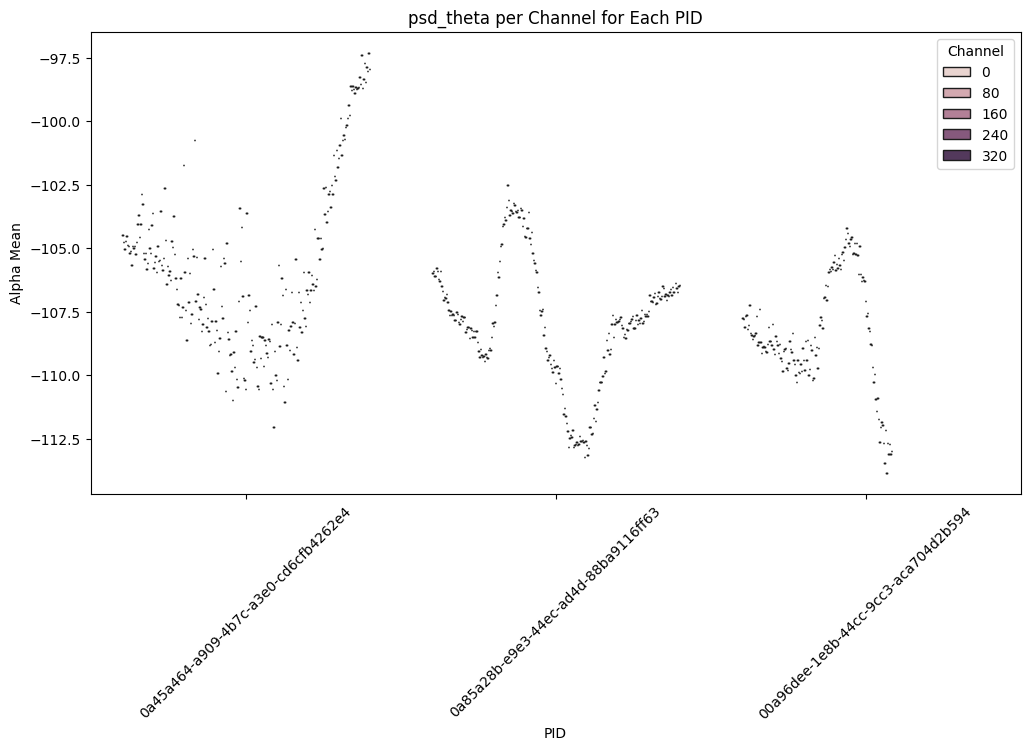

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_raw_features is your DataFrame

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_voltage[0:1000], x="pid", y="psd_theta", hue="channel")

plt.xticks(rotation=45)
plt.xlabel("PID")
plt.ylabel("Alpha Mean")
plt.title("psd_theta per Channel for Each PID")
plt.legend(title="Channel")
plt.show()


In [6]:
df_voltage

alpha_mean   alpha_std  \
pid                                  channel                           
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0        197.210450  190.478658   
                                     1        194.839222  186.516420   
                                     2        138.978804  195.718681   
                                     3        169.178477  110.850311   
                                     4        122.773706   80.443544   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      115.299620   74.028424   
                                     380      142.860548   94.239179   
                                     381      147.808486  133.909545   
                                     382      196.486313  194.143250   
                                     383      171.983269  147.854649   

                                              spike_count  peak_time_secs  \
pid                                  channel                                
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0                786        0.000025   
                                     1               1219        0.000024   
                                     2               1413        0.000027   
                                     3                399        0.000026   
                                     4                612        0.000022   
...                                                   ...             ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379              361        0.000006   
                                     380              513        0.000006   
                                     381             1029        0.000004   
                                     382              578        0.000005   
                                     383              501        0.000010   

                                              peak_val  trough_time_secs  \
pid                                  channel                               
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0       -3.364660          0.000339   
                                     1       -3.251131          0.000342   
                                     2       -3.822328          0.000341   
                                     3       -2.894536          0.000360   
                                     4       -2.923776          0.000340   
...                                                ...               ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -0.758633          0.000362   
                                     380     -1.222476          0.000360   
                                     381     -0.817315          0.000359   
                                     382     -1.281809          0.000351   
                                     383     -1.107193          0.000354   

                                              trough_val  tip_time_secs  \
pid                                  channel                              
0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0          1.418666      -0.000378   
                                     1          1.362056      -0.000367   
                                     2          1.580183      -0.000375   
                                     3          1.176652      -0.000378   
                                     4          1.230062      -0.000365   
...                                                  ...            ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379        0.270088      -0.000432   
                                     380        0.445692      -0.000432   
                                     381        0.279528      -0.000433   
                                     382        0.445679      -0.000405   
                                     383        0.445684      -0.000433   

                                               tip_val  recovery_time_secs  \
pid                                  channel                    

In [ ]:
aids = brain_atlas.get_labels(df_features.loc[:, ['x', 'y', 'z']].values, mode='clip')
df_features['Allen_id'] = aids
df_features['Cosmos_id'] = brain_atlas.regions.remap(aids, 'Allen', 'Cosmos')
df_features['Beryl_id'] = brain_atlas.regions.remap(aids, 'Allen', 'Beryl')

TRAIN_LABEL = 'Cosmos_id'  # ['Beryl_id', 'Cosmos_id']

In [8]:

from pathlib import Path

from one.api import ONE
from one.remote import aws
import ephys_atlas.data

config = ephys_atlas.data.get_config()
LOCAL_DATA_PATH = Path(config["paths"]["raw-samples"])

one = ONE(base_url="https://alyx.internationalbrainlab.org", mode="remote")
s3, bucket_name = aws.get_s3_from_alyx(alyx=one.alyx)


pids = [
    "1a276285-8b0e-4cc9-9f0a-a3a002978724",
    "1e104bf4-7a24-4624-a5b2-c2c8289c0de7",
    "5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e",
    "5f7766ce-8e2e-410c-9195-6bf089fea4fd",
    "6638cfb3-3831-4fc2-9327-194b76cf22e1",
    "749cb2b7-e57e-4453-a794-f6230e4d0226",
    "d7ec0892-0a6c-4f4f-9d8f-72083692af5c",
    "da8dfec1-d265-44e8-84ce-6ae9c109b8bd",
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "dc7e9403-19f7-409f-9240-05ee57cb7aea",
    "e8f9fba4-d151-4b00-bee7-447f0f3e752c",
    "eebcaf65-7fa4-4118-869d-a084e84530e2",
    "fe380793-8035-414e-b000-09bfe5ece92a",
]

# downloads all pids (52 Gb total)
if False:
    aws.s3_download_folder(
        "resources/ephys-atlas-sample", LOCAL_DATA_PATH, s3=s3, bucket_name=bucket_name
    )

# downloads one pid at a time (3 to 7 Gb a pop)
if False:
    pid = pids[5]
    aws.s3_download_folder(
        f"resources/ephys-atlas-sample/{pid}",
        LOCAL_DATA_PATH.joinpath(pid),
        s3=s3,
        bucket_name=bucket_name,
    )

In [9]:

from pathlib import Path
import numpy as np

import sklearn.metrics
from xgboost import (
    XGBClassifier,
)  # pip install xgboost  # https://xgboost.readthedocs.io/en/stable/prediction.html

from iblutil.numerical import ismember
from iblutil.util import Bunch

import ephys_atlas.data
import ephys_atlas.encoding
import ephys_atlas.decoding
import ephys_atlas.anatomy
import ephys_atlas.features

In [45]:

from pathlib import Path

from one.api import ONE
from one.remote import aws
import ephys_atlas.data

config = ephys_atlas.data.get_config()
LOCAL_DATA_PATH = Path(config["paths"]["raw-samples"])

one = ONE(base_url="https://alyx.internationalbrainlab.org", mode="remote")
s3, bucket_name = aws.get_s3_from_alyx(alyx=one.alyx)


pids = [
    "1a276285-8b0e-4cc9-9f0a-a3a002978724",
    "1e104bf4-7a24-4624-a5b2-c2c8289c0de7",
    "5d570bf6-a4c6-4bf1-a14b-2c878c84ef0e",
    "5f7766ce-8e2e-410c-9195-6bf089fea4fd",
    "6638cfb3-3831-4fc2-9327-194b76cf22e1",
    "749cb2b7-e57e-4453-a794-f6230e4d0226",
    "d7ec0892-0a6c-4f4f-9d8f-72083692af5c",
    "da8dfec1-d265-44e8-84ce-6ae9c109b8bd",
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "dc7e9403-19f7-409f-9240-05ee57cb7aea",
    "e8f9fba4-d151-4b00-bee7-447f0f3e752c",
    "eebcaf65-7fa4-4118-869d-a084e84530e2",
    "fe380793-8035-414e-b000-09bfe5ece92a",
]

# downloads all pids (52 Gb total)
if False:
    aws.s3_download_folder(
        "resources/ephys-atlas-sample", LOCAL_DATA_PATH, s3=s3, bucket_name=bucket_name
    )

# downloads one pid at a time (3 to 7 Gb a pop)
if False:
    pid = pids[5]
    aws.s3_download_folder(
        f"resources/ephys-atlas-sample/{pid}",
        LOCAL_DATA_PATH.joinpath(pid),
        s3=s3,
        bucket_name=bucket_name,
    )

In [46]:
from pathlib import Path
import pandas as pd
import numpy as np

import sklearn.metrics
from xgboost import XGBClassifier  # pip install xgboost  # https://xgboost.readthedocs.io/en/stable/prediction.html

from iblutil.numerical import ismember
import ephys_atlas.encoding
import ephys_atlas.decoding
import ephys_atlas.anatomy
import ephys_atlas.data
import ephys_atlas.features

In [48]:

import ephys_atlas.data
from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org', mode='remote')
df_voltage, _, df_channels, df_probes = ephys_atlas.data.download_tables(local_path='/home/ibladmin/Downloads/latest/', label='latest', one=one) #2024_W50


/home/ibladmin/Downloads/latest/latest/2023_W30.info: 0.00B [00:00, ?B/s]
/home/ibladmin/Downloads/latest/latest/2023_W34.info: 0.00B [00:00, ?B/s]
/home/ibladmin/Downloads/latest/latest/2023_W39.info: 0.00B [00:00, ?B/s]
/home/ibladmin/Downloads/latest/latest/2023_W41.info: 0.00B [00:00, ?B/s]
/home/ibladmin/Downloads/latest/latest/2023_W51.info: 0.00B [00:00, ?B/s]
/home/ibladmin/Downloads/latest/latest/2024_W04.info: 0.00B [00:00, ?B/s]
/home/ibladmin/Downloads/latest/latest/channels.pqt: 100%|██████████| 7.70M/7.70M [00:20<00:00, 372kB/s]
/home/ibladmin/Downloads/latest/latest/clusters.pqt: 100%|██████████| 73.7M/73.7M [00:11<00:00, 6.16MB/s]
/home/ibladmin/Downloads/latest/latest/clusters_correlograms.npy: 100%|██████████| 1.07G/1.07G [00:41<00:00, 26.0MB/s]
/home/ibladmin/Downloads/latest/latest/probes.pqt: 100%|██████████| 92.0k/92.0k [00:00<00:00, 242kB/s]
/home/ibladmin/Downloads/latest/latest/raw_ephys_features.pqt: 100%|██████████| 84.9M/84.9M [00:07<00:00, 11.6MB/s]


In [52]:
# %%
from pathlib import Path
import pandas as pd
import numpy as np

import sklearn.metrics
from xgboost import XGBClassifier  # pip install xgboost  # https://xgboost.readthedocs.io/en/stable/prediction.html

from iblutil.numerical import ismember
import ephys_atlas.encoding
import ephys_atlas.decoding
import ephys_atlas.anatomy
import ephys_atlas.data
import ephys_atlas.features

In [53]:

brain_atlas = ephys_atlas.anatomy.AllenAtlas()  # Accuracy: 0.5536619920744102

In [64]:
path_features = Path('/home/ibladmin/Downloads/latest/')  # mac

In [65]:
df_features = pd.read_parquet(path_features / 'raw_ephys_features.pqt')

In [66]:
df_features = df_features.merge(pd.read_parquet(path_features / 'channels.pqt'), how='inner', right_index=True, left_index=True)
df_features = df_features.merge(pd.read_parquet(path_features / 'channels_labels.pqt').fillna(0), how='inner', right_index=True, left_index=True)
ephys_atlas.data.load_tables(local_path=path_features) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/ibladmin/Downloads/latest/channels_labels.pqt'

In [58]:
df_features.columns

Index(['alpha_mean', 'alpha_std', 'spike_count', 'peak_time_secs', 'peak_val',
       'trough_time_secs', 'trough_val', 'tip_time_secs', 'tip_val',
       'recovery_time_secs', 'depolarisation_slope', 'repolarisation_slope',
       'recovery_slope', 'polarity', 'rms_ap', 'rms_lf', 'psd_delta',
       'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma', 'psd_lfp',
       'rms_lf_csd', 'psd_delta_csd', 'psd_theta_csd', 'psd_alpha_csd',
       'psd_beta_csd', 'psd_gamma_csd', 'psd_lfp_csd', 'x', 'y', 'z',
       'acronym', 'atlas_id', 'axial_um', 'lateral_um', 'histology', 'version',
       'x_target', 'y_target', 'z_target', 'atlas_id_target'],
      dtype='object')

In [59]:
ephys_atlas.data.load_tables(local_path=path_features)

(                                              alpha_mean   alpha_std  \
 pid                                  channel                           
 0a45a464-a909-4b7c-a3e0-cd6cfb4262e4 0        197.210450  190.478658   
                                      1        194.839222  186.516420   
                                      2        138.978804  195.718681   
                                      3        169.178477  110.850311   
                                      4        122.773706   80.443544   
 ...                                                  ...         ...   
 ffb1b072-2de7-44a4-8115-5799b9866382 379      115.299620   74.028424   
                                      380      142.860548   94.239179   
                                      381      147.808486  133.909545   
                                      382      196.486313  194.143250   
                                      383      171.983269  147.854649   
 
                                               sp

In [60]:
FEATURE_SET = ['raw_lf', 'raw_lf_csd', 'raw_ap', 'localisation', 'waveforms', 'micro-manipulator']
FEATURE_SET = ['raw_lf', 'raw_lf_csd', 'raw_ap', 'micro-manipulator']
x_list = ephys_atlas.features.voltage_features_set(FEATURE_SET)

In [61]:
df_features['outside'] = df_features['labels'] == 3
x_list.append('outside')



KeyError: 'labels'

In [35]:
aids = brain_atlas.get_labels(df_features.loc[:, ['x', 'y', 'z']].values, mode='clip')
df_features['Allen_id'] = aids
df_features['Cosmos_id'] = brain_atlas.regions.remap(aids, 'Allen', 'Cosmos')
df_features['Beryl_id'] = brain_atlas.regions.remap(aids, 'Allen', 'Beryl')

TRAIN_LABEL = 'Cosmos_id'  # ['Beryl_id', 'Cosmos_id']

KeyError: "None of [Index(['x', 'y', 'z'], dtype='object')] are in the [columns]"

In [164]:
test_sets = {
    'benchmark': ephys_atlas.data.BENCHMARK_PIDS,
    'nemo': ephys_atlas.data.NEMO_TEST_PIDS,
}
all_classes = np.unique(df_features.loc[:, TRAIN_LABEL])

In [165]:
def train(test_idx, fold_label):

    train_idx = ~test_idx
    print(f"{fold_label}: {df_features.shape[0]} channels", f'training set {np.sum(test_idx) / test_idx.size}')
    df_features.loc[train_idx, :].groupby(TRAIN_LABEL).count()
    x_train = df_features.loc[train_idx, x_list].values
    x_test = df_features.loc[test_idx, x_list].values
    y_train = df_features.loc[train_idx, TRAIN_LABEL].values
    y_test = df_features.loc[test_idx, TRAIN_LABEL].values
    df_benchmarks = df_features.loc[ismember(df_features.index.get_level_values(0), ephys_atlas.data.BENCHMARK_PIDS)[0], :].copy()
    df_test = df_features.loc[test_idx, :].copy()
    classes = np.unique(df_features.loc[train_idx, TRAIN_LABEL])

    _, iy_train = ismember(y_train, classes)
    _, iy_test = ismember(y_test, classes)
    # 0.5376271321378102
    #  create model instance
    classifier = XGBClassifier(device='gpu', verbosity=2)

    # fit model
    classifier.fit(x_train, iy_train)
    # make predictions
    y_pred = classes[classifier.predict(x_test)]
    df_test[f'cosmos_prediction'] = classes[classifier.predict(df_test.loc[:, x_list].values)]
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred, normalize='true')  # row: true, col: predicted
    print(f"{fold_label} Accuracy: {accuracy}")

    np.testing.assert_array_equal(classes, all_classes)
    return classifier.predict_proba(x_test), classifier, accuracy


In [31]:

# IDENTIFIER = 'lid-basket-sense'
# IDENTIFIER = 'voter-snap-pudding'
# n_folds = 5
# all_pids = np.array(df_features.index.get_level_values(0).unique())
# np.random.seed(12345)
# np.random.shuffle(all_pids)
# ifold = np.floor(np.arange(len(all_pids)) / len(all_pids) * n_folds)

# df_predictions = pd.DataFrame(index=df_features.index, columns=list(all_classes))
# for i in range(n_folds):
#     test_pids = all_pids[ifold == i]
#     test_idx = np.isin(df_features.index.get_level_values(0), test_pids)
#     probas, classifier, accuracy = train(test_idx=test_idx, fold_label=f'fold {i}')
#     df_predictions.loc[test_idx, all_classes] = probas
#     meta = dict(
#         RANDOM_SEED=713705,
#         VINTAGE="2024_W50",
#         REGION_MAP="Cosmos",
#         FEATURES=x_list,
#         CLASSES=[int(c) for c in all_classes],
#         ACCURACY=accuracy,
#         )
#     path_model = ephys_atlas.decoding.save_model(path_models, classifier, meta, subfolder=f'FOLD{i :02d}', identifier=IDENTIFIER)

# df_predictions.to_parquet(path_models / 'predictions_Cosmos.pqt')

fold 0: 384215 channels training set 0.2008120453391981
[15:24:07] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (307060, 20, 6141200).
[15:24:07] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.


/mnt/h0/kb/code_kcenia/.venv/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [15:24:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


fold 0 Accuracy: 0.6327911347287927
fold 1: 384215 channels training set 0.19975013989563134
[15:24:14] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (307468, 20, 6149360).
[15:24:14] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
fold 1 Accuracy: 0.6134311438883605
fold 2: 384215 channels training set 0.20078601824499304
[15:24:20] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (307070, 20, 6141400).
[15:24:20] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
fold 2 Accuracy: 0.6486356860457579
fold 3: 384215 channels training set 0.19982041304998505
[15:24:26] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (307441, 20, 6148820).
[15:24:26] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
fold 3 Accuracy: 0.6651861307213379
fold 4: 384215 channels training set 0.19883138347019247
[15:24:

In [166]:
df_features.columns

Index(['rms_ap', 'cor_ratio', 'rms_lf', 'psd_delta', 'psd_theta', 'psd_alpha',
       'psd_beta', 'psd_gamma', 'psd_lfp', 'rms_lf_csd', 'psd_delta_csd',
       'psd_theta_csd', 'psd_alpha_csd', 'psd_beta_csd', 'psd_gamma_csd',
       'psd_lfp_csd', 'alpha_mean', 'alpha_std', 'spike_count',
       'peak_time_secs', 'peak_val', 'trough_time_secs', 'trough_val',
       'tip_time_secs', 'tip_val', 'recovery_time_secs',
       'depolarisation_slope', 'repolarisation_slope', 'recovery_slope',
       'polarity', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um',
       'lateral_um', 'x_target', 'y_target', 'z_target', 'atlas_id_target',
       'labels', 'outside', 'Allen_id', 'Cosmos_id', 'Beryl_id'],
      dtype='object')

In [63]:
#https://github.com/int-brain-lab/ibldevtools/blob/581c407909a5c3f983cd6e3cdb4d66628a59f1d0/Mayo/2020-12-02_histology_slice_repeated_site.py#L23 
from pathlib import Path

import numpy as np

import ibllib.atlas as atlas
# from oneibl.one import ONE
import brainbox.io.one as bbone
# import atlaselectrophysiology.load_histology as hist
import matplotlib.pyplot as plt
from ibllib.pipes import ephys_alignment
import matplotlib
import os

one = ONE()
ba = atlas.AllenAtlas(25)

# Find eid of interest
traj = one.alyx.rest('trajectories', 'list', provenance='Planned',
                     x=-2243, y=-2000,  # repeated site coordinate
                     project='ibl_neuropixel_brainwide_01',
                     django='probe_insertion__session__qc__lt,'
                            '50,probe_insertion__json__extended_qc__tracing_exists,True,'
                            'probe_insertion__json__extended_qc__alignment_resolved,True')
probe_insertion = [t['probe_insertion'] for t in traj]

/mnt/h0/kb/code_kcenia/.venv/lib/python3.10/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


In [64]:
probe_insertion

['0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
 'e42e948c-3154-45cb-bf52-408b7cda0f2f',
 'ce397420-3cd2-4a55-8fd1-5e28321981f4',
 'e4ce2e94-6fb9-4afe-acbf-6f5a3498602e',
 'b83407f8-8220-46f9-9b90-a4c9f150c572',
 '92822789-608f-44a6-ad64-fe549402b2df',
 'f4bd76a6-66c9-41f3-9311-6962315f8fc8',
 '3d3d5a5e-df26-43ee-80b6-2d72d85668a5',
 'e31b4e39-e350-47a9-aca4-72496d99ff2a',
 'f8d0ecdc-b7bd-44cc-b887-3d544e24e561',
 '6fc4d73c-2071-43ec-a756-c6c6d8322c8b',
 '4836a465-c691-4852-a0b1-dcd2b1ce38a1',
 '1e176f17-d00f-49bb-87ff-26d237b525f1',
 '92033a0c-5a14-471b-b131-d43c72ca5d7a',
 '16799c7a-e395-435d-a4c4-a678007e1550',
 'b25799a5-09e8-4656-9c1b-44bc9cbb5279',
 'c17772a9-21b5-49df-ab31-3017addea12e',
 '22212d26-a167-45fb-9963-35ecd003e8a2',
 'ef3d059a-59d5-4870-b355-563a8d7cfd2d',
 '0851db85-2889-4070-ac18-a40e8ebd96ba',
 'eeb27b45-5b85-4e5c-b6ff-f639ca5687de',
 '69f42a9c-095d-4a25-bca8-61a9869871d3',
 '8c732bf2-639d-496c-bf82-464bc9c2d54b',
 'f03b61b4-6b13-479d-940f-d1608eb275cc',
 'b2746c16-7152-

In [65]:
len(probe_insertion)

95

In [66]:
df_features

pid  channel    rms_ap  cor_ratio  \
0       00a824c0-e060-495f-9ebc-79c82fef4c67        0  0.000026   0.754190   
1       00a824c0-e060-495f-9ebc-79c82fef4c67        1  0.000026   0.411007   
2       00a824c0-e060-495f-9ebc-79c82fef4c67        2  0.000026   0.451987   
3       00a824c0-e060-495f-9ebc-79c82fef4c67        3  0.000026   0.469155   
4       00a824c0-e060-495f-9ebc-79c82fef4c67        4  0.000026   0.338838   
...                                      ...      ...       ...        ...   
384210  ffb1b072-2de7-44a4-8115-5799b9866382      379  0.000038   0.788894   
384211  ffb1b072-2de7-44a4-8115-5799b9866382      380  0.000038   0.766668   
384212  ffb1b072-2de7-44a4-8115-5799b9866382      381  0.000038   0.744558   
384213  ffb1b072-2de7-44a4-8115-5799b9866382      382  0.000038   0.696702   
384214  ffb1b072-2de7-44a4-8115-5799b9866382      383  0.000038   0.695542   

          rms_lf   psd_delta   psd_theta   psd_alpha    psd_beta   psd_gamma  \
0       0.000029 -101.787283 -104.159496 -105.973834 -112.510019 -115.888470   
1       0.000030 -101.573927 -104.459178 -106.397486 -112.693430 -115.906262   
2       0.000031 -101.712161 -104.223009 -106.204256 -112.325320 -115.555288   
3       0.000041  -97.225263 -102.353363 -104.408635 -110.429818 -114.125412   
4       0.000033  -99.494953 -104.781015 -106.740744 -112.371962 -115.086073   
...          ...         ...         ...         ...         ...         ...   
384210  0.000045  -96.893853 -101.622061 -104.861699 -110.253048 -113.620168   
384211  0.000047  -96.756403 -101.407902 -104.768071 -110.041355 -113.450934   
384212  0.000046  -97.154323 -101.746486 -104.903059 -110.157332 -113.669899   
384213  0.000048  -96.286040 -101.416863 -104.826851 -109.906594 -113.303112   
384214  0.000046  -97.056808 -101.644340 -105.094410 -110.118663 -113.458966   

        ...  lateral_um  x_target  y_target  z_target  atlas_id_target  \
0       ...        43.0 -0.000352 -0.002844 -0.003299              795   
1       ...        11.0 -0.000352 -0.002844 -0.003299              795   
2       ...        59.0 -0.000357 -0.002844 -0.003279              795   
3       ...        27.0 -0.000357 -0.002844 -0.003279              795   
4       ...        43.0 -0.000362 -0.002844 -0.003260              795   
...     ...         ...       ...       ...       ...              ...   
384210  ...        27.0  0.001347 -0.006209 -0.003445              512   
384211  ...        43.0  0.001350 -0.006209 -0.003426              512   
384212  ...        11.0  0.001350 -0.006209 -0.003426              512   
384213  ...        59.0  0.001353 -0.006209 -0.003406              512   
384214  ...        27.0  0.001353 -0.006209 -0.003406              512   

        labels  outside  Allen_id  Cosmos_id  Beryl_id  
0          2.0    False       128        313       128  
1          0.0    False       128        313       128  
2          0.0    False       128        313       128  
3          0.0    False       128        313       128  
4          0.0    False       128        313       128  
...        ...      ...       ...        ...       ...  
384210     0.0    False      1025        512      1025  
384211     0.0    False      1025        512      1025  
384212     0.0    False      1025        512      1025  
384213     0.0    False      1025        512      1025  
384214     0.0    False      1025        512      1025  

[384215 rows x 48 columns]

In [67]:
df_voltage

rms_ap  cor_ratio    rms_lf  \
pid                                  channel                                  
00a824c0-e060-495f-9ebc-79c82fef4c67 0        0.000026   0.754190  0.000029   
                                     1        0.000026   0.411007  0.000030   
                                     2        0.000026   0.451987  0.000031   
                                     3        0.000026   0.469155  0.000041   
                                     4        0.000026   0.338838  0.000033   
...                                                ...        ...       ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      0.000038   0.788894  0.000045   
                                     380      0.000038   0.766668  0.000047   
                                     381      0.000038   0.744558  0.000046   
                                     382      0.000038   0.696702  0.000048   
                                     383      0.000038   0.695542  0.000046   

                                               psd_delta   psd_theta  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -101.787283 -104.159496   
                                     1       -101.573927 -104.459178   
                                     2       -101.712161 -104.223009   
                                     3        -97.225263 -102.353363   
                                     4        -99.494953 -104.781015   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      -96.893853 -101.622061   
                                     380      -96.756403 -101.407902   
                                     381      -97.154323 -101.746486   
                                     382      -96.286040 -101.416863   
                                     383      -97.056808 -101.644340   

                                               psd_alpha    psd_beta  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -105.973834 -112.510019   
                                     1       -106.397486 -112.693430   
                                     2       -106.204256 -112.325320   
                                     3       -104.408635 -110.429818   
                                     4       -106.740744 -112.371962   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -104.861699 -110.253048   
                                     380     -104.768071 -110.041355   
                                     381     -104.903059 -110.157332   
                                     382     -104.826851 -109.906594   
                                     383     -105.094410 -110.118663   

                                               psd_gamma     psd_lfp  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -115.888470 -112.043098   
                                     1       -115.906262 -111.789864   
                                     2       -115.555288 -111.863034   
                                     3       -114.125412 -109.164580   
                                     4       -115.086073 -111.196320   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -113.620168 -108.627753   
                                     380     -113.450934 -108.257603   
                                     381     -113.669899 -108.536956   
                                     382     -113.303112 -108.127909   
                                     383     -113.458966 -108.403703   

                                                rms_lf_csd  ...  peak_val  \
pid                                  channel                ...             
00a824c0-e060-495f-9ebc-79c82fef4c67 0        5.301135e

In [68]:
import pandas as pd

df_features = df_features.reset_index()

# Filter df_features to keep only rows where 'pid' is in probe_insertion
df_features_rs = df_features[df_features['pid'].isin(probe_insertion)]

# Display the filtered dataframe
print(df_features_rs)


         index                                   pid  channel    rms_ap  \
4608      4608  02cc03e4-8015-4050-bb42-6c832091febb        0  0.000021   
4609      4609  02cc03e4-8015-4050-bb42-6c832091febb        1  0.000021   
4610      4610  02cc03e4-8015-4050-bb42-6c832091febb        2  0.000021   
4611      4611  02cc03e4-8015-4050-bb42-6c832091febb        3  0.000021   
4612      4612  02cc03e4-8015-4050-bb42-6c832091febb        4  0.000021   
...        ...                                   ...      ...       ...   
383443  383443  febb430e-2d50-4f83-87a0-b5ffbb9a4943      379  0.000010   
383444  383444  febb430e-2d50-4f83-87a0-b5ffbb9a4943      380  0.000010   
383445  383445  febb430e-2d50-4f83-87a0-b5ffbb9a4943      381  0.000010   
383446  383446  febb430e-2d50-4f83-87a0-b5ffbb9a4943      382  0.000010   
383447  383447  febb430e-2d50-4f83-87a0-b5ffbb9a4943      383  0.000010   

        cor_ratio    rms_lf   psd_delta   psd_theta   psd_alpha    psd_beta  \
4608     0.557105  0

In [69]:
df_features_rs = df_features_rs.reset_index()  

In [70]:
df_features_rs


level_0   index                                   pid  channel  \
0         4608    4608  02cc03e4-8015-4050-bb42-6c832091febb        0   
1         4609    4609  02cc03e4-8015-4050-bb42-6c832091febb        1   
2         4610    4610  02cc03e4-8015-4050-bb42-6c832091febb        2   
3         4611    4611  02cc03e4-8015-4050-bb42-6c832091febb        3   
4         4612    4612  02cc03e4-8015-4050-bb42-6c832091febb        4   
...        ...     ...                                   ...      ...   
36469   383443  383443  febb430e-2d50-4f83-87a0-b5ffbb9a4943      379   
36470   383444  383444  febb430e-2d50-4f83-87a0-b5ffbb9a4943      380   
36471   383445  383445  febb430e-2d50-4f83-87a0-b5ffbb9a4943      381   
36472   383446  383446  febb430e-2d50-4f83-87a0-b5ffbb9a4943      382   
36473   383447  383447  febb430e-2d50-4f83-87a0-b5ffbb9a4943      383   

         rms_ap  cor_ratio    rms_lf   psd_delta   psd_theta   psd_alpha  ...  \
0      0.000021   0.557105  0.000027 -101.823416 -104.897197 -108.029052  ...   
1      0.000021   0.499335  0.000028 -101.325126 -104.684551 -107.898570  ...   
2      0.000021   0.512788  0.000026 -101.866288 -105.270339 -108.259699  ...   
3      0.000021   0.540980  0.000027 -101.616987 -104.816437 -108.255451  ...   
4      0.000021   0.553821  0.000026 -101.871551 -104.948605 -108.252515  ...   
...         ...        ...       ...         ...         ...         ...  ...   
36469  0.000010   0.276007  0.000093  -90.390155  -92.594649  -96.015475  ...   
36470  0.000010   0.274785  0.000092  -90.469792  -92.616869  -96.139506  ...   
36471  0.000010   0.282201  0.000093  -90.335250  -92.631347  -96.102832  ...   
36472  0.000010   0.270047  0.000091  -90.656129  -92.760258  -96.238402  ...   
36473  0.000010   0.264226  0.000092  -90.466512  -92.710591  -96.214466  ...   

       lateral_um  x_target  y_target  z_target  atlas_id_target  labels  \
0            43.0 -0.001159 -0.001848 -0.004385              685     0.0   
1            11.0 -0.001159 -0.001848 -0.004385              685     0.0   
2            59.0 -0.001164 -0.001848 -0.004366              685     0.0   
3            27.0 -0.001164 -0.001848 -0.004366              685     0.0   
4            43.0 -0.001169 -0.001848 -0.004346              685     0.0   
...           ...       ...       ...       ...              ...     ...   
36469        27.0 -0.002147 -0.001840 -0.000519        312782558     0.0   
36470        43.0 -0.002152 -0.001840 -0.000500        312782558     0.0   
36471        11.0 -0.002152 -0.001840 -0.000500        312782558     0.0   
36472        59.0 -0.002157 -0.001840 -0.000481        312782554     0.0   
36473        27.0 -0.002157 -0.001840 -0.000481        312782554     0.0   

       outside  Allen_id  Cosmos_id  Beryl_id  
0        False       128        313       128  
1        False       128        313       128  
2        False       128        313       128  
3        False       128        313       128  
4        False       128        313       128  
...        ...       ...        ...       ...  
36469    False       721        315       385  
36470    False       721        315       385  
36471    False       721        315       385  
36472    False       721        315       385  
36473    False       721        315       385  

[36474 rows x 50 columns]

In [71]:
# https://int-brain-lab.github.io/iblenv/notebooks_external/atlas_mapping.html
# import brain atlas and brain regions objects
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
ba = AllenAtlas()
br = BrainRegions() # br is also an attribute of ba so could to br = ba.regions

cosmos_indices = np.unique(br.mappings['Cosmos'])
br.acronym[cosmos_indices]


array(['void', 'root', 'Isocortex', 'OLF', 'HPF', 'CTXsp', 'CNU', 'TH',
       'HY', 'MB', 'HB', 'CB'], dtype=object)

In [72]:
# First find the atlas_id associated with acronym MDm
atlas_id = br.acronym2id('Isocortex')
# Then find the acronyms of the ancestors of this region
print(br.ancestors(ids=atlas_id)['acronym'])

['root' 'grey' 'CH' 'CTX' 'CTXpl' 'Isocortex']


In [73]:
print(br.acronym2acronym('Isocortex', mapping='Allen'))

['Isocortex']


In [74]:
print(br.acronym2acronym('Isocortex', mapping='Cosmos'))

['Isocortex']


In [75]:
print(br.acronym2id('Isocortex', mapping='Cosmos'))
print(br.acronym2id('Isocortex', mapping='Beryl'))
print(br.acronym2id('Isocortex', mapping='Allen'))

[315]
[997]
[315]


In [76]:
df_features_rs.Allen_id.unique()

array([      128,       215,       313,       916,      1009,     10703,
             632,       382,       466,       971, 484682520,       940,
       312782570, 312782566, 312782562, 560581551,       549,       218,
            1029,     10704,       986,       441,      1046,       433,
             401,      1066,       281,         0,       997, 312782558,
       312782554, 312782550,       797,       804,      1097,       697,
             733,      1020,       463, 484682512, 496345668, 496345672,
       496345664, 563807435,       325,       422,      1088,       469,
             257,       565,       501,        41,       805,       628,
            1089,       502, 484682470,       443,        17,        10,
             305,        33,       778,       725,       721,       214,
             146,      1052,       246,      1061,       821,       718,
       484682524,       423,       155, 484682516,       461,         9,
            1111,      1086,       670,       593, 

In [77]:
df_features_rs.shape

(36474, 50)

In [78]:
df_features_rs_isocortex_cosmos = df_features_rs[df_features_rs['Cosmos_id'] == 315]

In [85]:
df_features_rs_isocortex_cosmos = df_features_rs_isocortex_cosmos.reset_index(drop=True)
df_features_rs_isocortex_cosmos.shape

(6369, 50)

In [86]:
df_features_rs_isocortex_cosmos

level_0   index                                   pid  channel  \
0        4960    4960  02cc03e4-8015-4050-bb42-6c832091febb      352   
1        4961    4961  02cc03e4-8015-4050-bb42-6c832091febb      353   
2        4962    4962  02cc03e4-8015-4050-bb42-6c832091febb      354   
3        4963    4963  02cc03e4-8015-4050-bb42-6c832091febb      355   
4        4964    4964  02cc03e4-8015-4050-bb42-6c832091febb      356   
...       ...     ...                                   ...      ...   
6364   383443  383443  febb430e-2d50-4f83-87a0-b5ffbb9a4943      379   
6365   383444  383444  febb430e-2d50-4f83-87a0-b5ffbb9a4943      380   
6366   383445  383445  febb430e-2d50-4f83-87a0-b5ffbb9a4943      381   
6367   383446  383446  febb430e-2d50-4f83-87a0-b5ffbb9a4943      382   
6368   383447  383447  febb430e-2d50-4f83-87a0-b5ffbb9a4943      383   

        rms_ap  cor_ratio    rms_lf  psd_delta  psd_theta  psd_alpha  ...  \
0     0.000011   0.366232  0.000136 -88.026229 -89.106191 -92.053162  ...   
1     0.000011   0.312016  0.000136 -88.131057 -89.135018 -92.075441  ...   
2     0.000011   0.280382  0.000136 -88.074661 -89.185030 -92.151970  ...   
3     0.000011   0.369324  0.000135 -88.304842 -89.215874 -92.099564  ...   
4     0.000012   0.338646  0.000135 -88.281858 -89.237349 -92.184661  ...   
...        ...        ...       ...        ...        ...        ...  ...   
6364  0.000010   0.276007  0.000093 -90.390155 -92.594649 -96.015475  ...   
6365  0.000010   0.274785  0.000092 -90.469792 -92.616869 -96.139506  ...   
6366  0.000010   0.282201  0.000093 -90.335250 -92.631347 -96.102832  ...   
6367  0.000010   0.270047  0.000091 -90.656129 -92.760258 -96.238402  ...   
6368  0.000010   0.264226  0.000092 -90.466512 -92.710591 -96.214466  ...   

      lateral_um  x_target  y_target  z_target  atlas_id_target  labels  \
0           43.0 -0.002029 -0.001848 -0.000974                9     0.0   
1           11.0 -0.002029 -0.001848 -0.000974                9     0.0   
2           59.0 -0.002034 -0.001848 -0.000955                9     0.0   
3           27.0 -0.002034 -0.001848 -0.000955                9     0.0   
4           43.0 -0.002039 -0.001848 -0.000936                9     0.0   
...          ...       ...       ...       ...              ...     ...   
6364        27.0 -0.002147 -0.001840 -0.000519        312782558     0.0   
6365        43.0 -0.002152 -0.001840 -0.000500        312782558     0.0   
6366        11.0 -0.002152 -0.001840 -0.000500        312782558     0.0   
6367        59.0 -0.002157 -0.001840 -0.000481        312782554     0.0   
6368        27.0 -0.002157 -0.001840 -0.000481        312782554     0.0   

      outside   Allen_id  Cosmos_id   Beryl_id  
0       False  312782570        315  312782546  
1       False  312782570        315  312782546  
2       False  312782566        315  312782546  
3       False  312782566        315  312782546  
4       False  312782566        315  312782546  
...       ...        ...        ...        ...  
6364    False        721        315        385  
6365    False        721        315        385  
6366    False        721        315        385  
6367    False        721        315        385  
6368    False        721        315        385  

[6369 rows x 50 columns]

In [87]:
df_features_rs_isocortex_allen = df_features_rs[df_features_rs['Allen_id'] == 315]
df_features_rs_isocortex_allen = df_features_rs_isocortex_allen.reset_index(drop=True)
df_features_rs_isocortex_allen.shape

(0, 50)

In [54]:
# pip install iblatlas --upgrade

In [55]:
from iblatlas.atlas import xyz_to_depth

In [83]:
df_features_rs_isocortex_cosmos

level_0   index                                   pid  channel  \
352       4960    4960  02cc03e4-8015-4050-bb42-6c832091febb      352   
353       4961    4961  02cc03e4-8015-4050-bb42-6c832091febb      353   
354       4962    4962  02cc03e4-8015-4050-bb42-6c832091febb      354   
355       4963    4963  02cc03e4-8015-4050-bb42-6c832091febb      355   
356       4964    4964  02cc03e4-8015-4050-bb42-6c832091febb      356   
...        ...     ...                                   ...      ...   
36469   383443  383443  febb430e-2d50-4f83-87a0-b5ffbb9a4943      379   
36470   383444  383444  febb430e-2d50-4f83-87a0-b5ffbb9a4943      380   
36471   383445  383445  febb430e-2d50-4f83-87a0-b5ffbb9a4943      381   
36472   383446  383446  febb430e-2d50-4f83-87a0-b5ffbb9a4943      382   
36473   383447  383447  febb430e-2d50-4f83-87a0-b5ffbb9a4943      383   

         rms_ap  cor_ratio    rms_lf  psd_delta  psd_theta  psd_alpha  ...  \
352    0.000011   0.366232  0.000136 -88.026229 -89.106191 -92.053162  ...   
353    0.000011   0.312016  0.000136 -88.131057 -89.135018 -92.075441  ...   
354    0.000011   0.280382  0.000136 -88.074661 -89.185030 -92.151970  ...   
355    0.000011   0.369324  0.000135 -88.304842 -89.215874 -92.099564  ...   
356    0.000012   0.338646  0.000135 -88.281858 -89.237349 -92.184661  ...   
...         ...        ...       ...        ...        ...        ...  ...   
36469  0.000010   0.276007  0.000093 -90.390155 -92.594649 -96.015475  ...   
36470  0.000010   0.274785  0.000092 -90.469792 -92.616869 -96.139506  ...   
36471  0.000010   0.282201  0.000093 -90.335250 -92.631347 -96.102832  ...   
36472  0.000010   0.270047  0.000091 -90.656129 -92.760258 -96.238402  ...   
36473  0.000010   0.264226  0.000092 -90.466512 -92.710591 -96.214466  ...   

       lateral_um  x_target  y_target  z_target  atlas_id_target  labels  \
352          43.0 -0.002029 -0.001848 -0.000974                9     0.0   
353          11.0 -0.002029 -0.001848 -0.000974                9     0.0   
354          59.0 -0.002034 -0.001848 -0.000955                9     0.0   
355          27.0 -0.002034 -0.001848 -0.000955                9     0.0   
356          43.0 -0.002039 -0.001848 -0.000936                9     0.0   
...           ...       ...       ...       ...              ...     ...   
36469        27.0 -0.002147 -0.001840 -0.000519        312782558     0.0   
36470        43.0 -0.002152 -0.001840 -0.000500        312782558     0.0   
36471        11.0 -0.002152 -0.001840 -0.000500        312782558     0.0   
36472        59.0 -0.002157 -0.001840 -0.000481        312782554     0.0   
36473        27.0 -0.002157 -0.001840 -0.000481        312782554     0.0   

       outside   Allen_id  Cosmos_id   Beryl_id  
352      False  312782570        315  312782546  
353      False  312782570        315  312782546  
354      False  312782566        315  312782546  
355      False  312782566        315  312782546  
356      False  312782566        315  312782546  
...        ...        ...        ...        ...  
36469    False        721        315        385  
36470    False        721        315        385  
36471    False        721        315        385  
36472    False        721        315        385  
36473    False        721        315        385  

[6369 rows x 50 columns]

In [90]:
# Collect the xyz coordinates into a full 2D array
xyz = df_features_rs_isocortex_cosmos[['x', 'y', 'z']].to_numpy()

# Pass the entire array to xyz_to_depth
depths = xyz_to_depth(xyz)

# Assign the result back to the DataFrame
df_features_rs_isocortex_cosmos['depths'] = depths


level_0  index                                   pid  channel    rms_ap  \
25     4985   4985  02cc03e4-8015-4050-bb42-6c832091febb      377  0.000014   
26     4986   4986  02cc03e4-8015-4050-bb42-6c832091febb      378  0.000014   
27     4987   4987  02cc03e4-8015-4050-bb42-6c832091febb      379  0.000014   
28     4988   4988  02cc03e4-8015-4050-bb42-6c832091febb      380  0.000014   
29     4989   4989  02cc03e4-8015-4050-bb42-6c832091febb      381  0.000014   
30     4990   4990  02cc03e4-8015-4050-bb42-6c832091febb      382  0.000014   
31     4991   4991  02cc03e4-8015-4050-bb42-6c832091febb      383  0.000014   
32    15952  15952  0851db85-2889-4070-ac18-a40e8ebd96ba      212  0.000013   
33    15953  15953  0851db85-2889-4070-ac18-a40e8ebd96ba      213  0.000013   
34    15954  15954  0851db85-2889-4070-ac18-a40e8ebd96ba      214  0.000013   
35    15955  15955  0851db85-2889-4070-ac18-a40e8ebd96ba      215  0.000013   
36    15956  15956  0851db85-2889-4070-ac18-a40e8ebd96ba      216  0.000013   
37    15957  15957  0851db85-2889-4070-ac18-a40e8ebd96ba      217  0.000013   
38    15958  15958  0851db85-2889-4070-ac18-a40e8ebd96ba      218  0.000013   
39    15959  15959  0851db85-2889-4070-ac18-a40e8ebd96ba      219  0.000013   
40    15960  15960  0851db85-2889-4070-ac18-a40e8ebd96ba      220  0.000013   
41    15961  15961  0851db85-2889-4070-ac18-a40e8ebd96ba      221  0.000013   
42    15962  15962  0851db85-2889-4070-ac18-a40e8ebd96ba      222  0.000013   
43    15963  15963  0851db85-2889-4070-ac18-a40e8ebd96ba      223  0.000013   
44    15964  15964  0851db85-2889-4070-ac18-a40e8ebd96ba      224  0.000013   
45    15965  15965  0851db85-2889-4070-ac18-a40e8ebd96ba      225  0.000013   
46    15966  15966  0851db85-2889-4070-ac18-a40e8ebd96ba      226  0.000013   
47    15967  15967  0851db85-2889-4070-ac18-a40e8ebd96ba      227  0.000013   
48    15968  15968  0851db85-2889-4070-ac18-a40e8ebd96ba      228  0.000013   
49    15969  15969  0851db85-2889-4070-ac18-a40e8ebd96ba      229  0.000013   
50    15970  15970  0851db85-2889-4070-ac18-a40e8ebd96ba      230  0.000014   
51    15971  15971  0851db85-2889-4070-ac18-a40e8ebd96ba      231  0.000014   
52    15972  15972  0851db85-2889-4070-ac18-a40e8ebd96ba      232  0.000014   
53    15973  15973  0851db85-2889-4070-ac18-a40e8ebd96ba      233  0.000014   
54    15974  15974  0851db85-2889-4070-ac18-a40e8ebd96ba      234  0.000014   

    cor_ratio    rms_lf  psd_delta  psd_theta   psd_alpha  ...  x_target  \
25   0.486616  0.000130 -88.474373 -89.447290  -92.590917  ... -0.002089   
26   0.404213  0.000131 -88.301918 -89.434023  -92.521122  ... -0.002094   
27   0.562908  0.000130 -88.462176 -89.491043  -92.614437  ... -0.002094   
28   0.451744  0.000130 -88.456890 -89.468265  -92.569320  ... -0.002099   
29   0.490055  0.000130 -88.433476 -89.427788  -92.580461  ... -0.002099   
30   0.466149  0.000130 -88.369518 -89.461624  -92.501263  ... -0.002103   
31   0.553201  0.000129 -88.465319 -89.489371  -92.571237  ... -0.002103   
32   0.136879  0.000069 -93.209018 -95.262261  -99.825611  ... -0.001352   
33   0.137192  0.000058 -96.206064 -96.251583 -100.382761  ... -0.001352   
34   0.140548  0.000065 -93.253895 -95.275102 -100.396126  ... -0.001357   
35   0.134186  0.000062 -94.704192 -95.728464 -100.370631  ... -0.001357   
36   0.160773  0.000069 -92.649905 -95.445118 -100.159286  ... -0.001362   
37   0.124290  0.000066 -93.894476 -95.803075 -100.260952  ... -0.001362   
38   0.134717  0.000069 -92.408102 -95.688558 -100.362790  ... -0.001367   
39   0.150332  0.000057 -95.726313 -96.585297 -100.894395  ... -0.001367   
40   0.138448  0.000059 -94.671995 -96.395510 -101.011153  ... -0.001371   
41   0.131701  0.000060 -94.818792 -95.851113 -101.077356  ... -0.001371   
42   0.119193  0.000071 -92.686060 -95.789373 -100.391951  ... -0.001376   
43   0.135812  0.000067 -93.671655 -95.683886 -100.446251  ... -0.001376   
44   0.130114  0.000047 -98.130345

In [93]:
df_features_rs_isocortex_cosmos['depths_norm'] = (
    df_features_rs_isocortex_cosmos['depths'] - df_features_rs_isocortex_cosmos['depths'].min()
) / (
    df_features_rs_isocortex_cosmos['depths'].max() - df_features_rs_isocortex_cosmos['depths'].min()
)


In [95]:
df_features_rs_isocortex_cosmos = df_features_rs_isocortex_cosmos.dropna(subset=['depths'])
df_features_rs_isocortex_cosmos = df_features_rs_isocortex_cosmos.reset_index(drop=True)
df_features_rs_isocortex_cosmos

level_0   index                                   pid  channel  \
0        4960    4960  02cc03e4-8015-4050-bb42-6c832091febb      352   
1        4962    4962  02cc03e4-8015-4050-bb42-6c832091febb      354   
2        4964    4964  02cc03e4-8015-4050-bb42-6c832091febb      356   
3        4966    4966  02cc03e4-8015-4050-bb42-6c832091febb      358   
4        4968    4968  02cc03e4-8015-4050-bb42-6c832091febb      360   
...       ...     ...                                   ...      ...   
2586   383438  383438  febb430e-2d50-4f83-87a0-b5ffbb9a4943      374   
2587   383440  383440  febb430e-2d50-4f83-87a0-b5ffbb9a4943      376   
2588   383442  383442  febb430e-2d50-4f83-87a0-b5ffbb9a4943      378   
2589   383444  383444  febb430e-2d50-4f83-87a0-b5ffbb9a4943      380   
2590   383446  383446  febb430e-2d50-4f83-87a0-b5ffbb9a4943      382   

        rms_ap  cor_ratio    rms_lf  psd_delta  psd_theta  psd_alpha  ...  \
0     0.000011   0.366232  0.000136 -88.026229 -89.106191 -92.053162  ...   
1     0.000011   0.280382  0.000136 -88.074661 -89.185030 -92.151970  ...   
2     0.000012   0.338646  0.000135 -88.281858 -89.237349 -92.184661  ...   
3     0.000012   0.308142  0.000135 -88.015468 -89.296740 -92.239936  ...   
4     0.000012   0.365317  0.000135 -88.157199 -89.255251 -92.186636  ...   
...        ...        ...       ...        ...        ...        ...  ...   
2586  0.000010   0.279272  0.000094 -90.238588 -92.447076 -95.938176  ...   
2587  0.000010   0.280332  0.000094 -90.268058 -92.478475 -95.980155  ...   
2588  0.000010   0.283466  0.000092 -90.422349 -92.666721 -96.098620  ...   
2589  0.000010   0.274785  0.000092 -90.469792 -92.616869 -96.139506  ...   
2590  0.000010   0.270047  0.000091 -90.656129 -92.760258 -96.238402  ...   

      y_target  z_target  atlas_id_target  labels  outside   Allen_id  \
0    -0.001848 -0.000974                9     0.0    False  312782570   
1    -0.001848 -0.000955                9     0.0    False  312782566   
2    -0.001848 -0.000936                9     0.0    False  312782566   
3    -0.001848 -0.000916                9     0.0    False  312782566   
4    -0.001848 -0.000897        312782566     0.0    False  312782566   
...        ...       ...              ...     ...      ...        ...   
2586 -0.001840 -0.000558        312782558     0.0    False        721   
2587 -0.001840 -0.000539        312782558     0.0    False        721   
2588 -0.001840 -0.000519        312782558     0.0    False        721   
2589 -0.001840 -0.000500        312782558     0.0    False        721   
2590 -0.001840 -0.000481        312782554     0.0    False        721   

      Cosmos_id   Beryl_id      depths  depths_norm  
0           315  312782546  811.888672     0.785350  
1           315  312782546  783.434204     0.757534  
2           315  312782546  755.541565     0.730268  
3           315  312782546  732.031372     0.707286  
4           315  312782546  725.813904     0.701208  
...         ...        ...         ...          ...  
2586        315        385  447.401276     0.429049  
2587        315        385  424.871094     0.407025  
2588        315        385  399.237732     0.381967  
2589        315        385  369.491272     0.352889  
2590        315        385  347.261139     0.331158  

[2591 rows x 52 columns]

Applying the sci-kit Linear Regression Model

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#1. Inputs x and target y
X = df_features_rs_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_rs_isocortex_cosmos['depths']

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.9947
Mean Squared Error: 299.6988


In [124]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [ 287032.73268577  -56332.84039541 -923429.83364867]
Intercept: 417.74060412633855


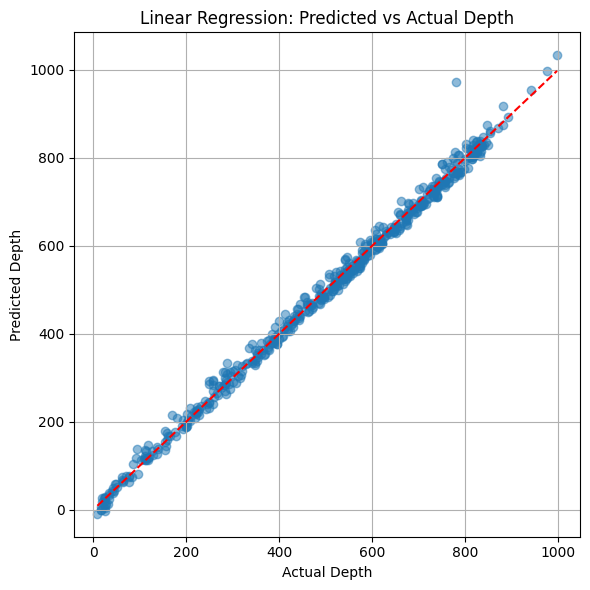

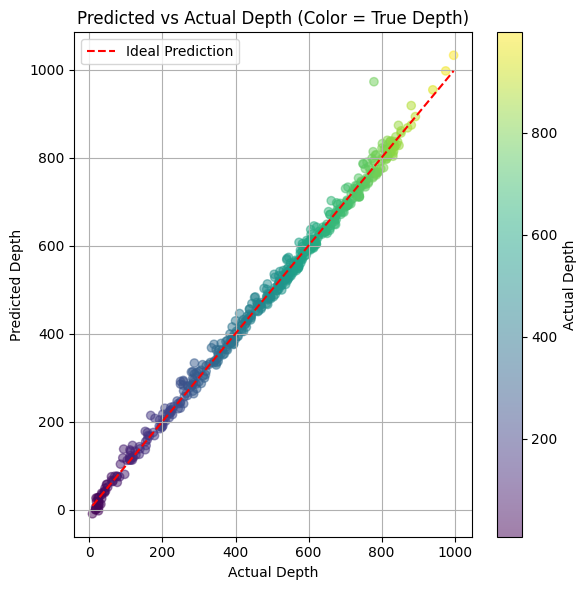

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.title('Linear Regression: Predicted vs Actual Depth')
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
scatter = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')

plt.xlabel('Actual Depth')
plt.ylabel('Predicted Depth')
plt.title('Predicted vs Actual Depth (Color = True Depth)')
plt.colorbar(scatter, label='Actual Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



predict the normalized depth 

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#1. Inputs x and target y
X = df_features_rs_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_rs_isocortex_cosmos['depths_norm']

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

R² score: 0.9947
Mean Squared Error: 0.0003


same but for all the pids 

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Collect the xyz coordinates into a full 2D array
xyz = df_features[['x', 'y', 'z']].to_numpy()

# Pass the entire array to xyz_to_depth
depths = xyz_to_depth(xyz)

# Assign the result back to the DataFrame
df_features['depths'] = depths

df_features['depths_norm'] = (
    df_features['depths'] - df_features['depths'].min()
) / (
    df_features['depths'].max() - df_features['depths'].min()
) 




df_features = df_features.dropna(subset=['depths'])
df_features = df_features.reset_index(drop=True)
df_features



#1. Inputs x and target y
X = df_features[['x', 'y', 'z']]
y = df_features['depths']

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.0780
Mean Squared Error: 100286.9284


In [119]:
df_features

index                                   pid  channel    rms_ap  \
0         202  00a824c0-e060-495f-9ebc-79c82fef4c67      202  0.000015   
1         204  00a824c0-e060-495f-9ebc-79c82fef4c67      204  0.000015   
2         206  00a824c0-e060-495f-9ebc-79c82fef4c67      206  0.000015   
3         208  00a824c0-e060-495f-9ebc-79c82fef4c67      208  0.000015   
4         210  00a824c0-e060-495f-9ebc-79c82fef4c67      210  0.000016   
...       ...                                   ...      ...       ...   
26668  383819  ff5fceaf-8247-42ab-a187-f7876441899d      372  0.000018   
26669  383821  ff5fceaf-8247-42ab-a187-f7876441899d      374  0.000018   
26670  383823  ff5fceaf-8247-42ab-a187-f7876441899d      376  0.000019   
26671  383827  ff5fceaf-8247-42ab-a187-f7876441899d      380  0.000019   
26672  383829  ff5fceaf-8247-42ab-a187-f7876441899d      382  0.000019   

       cor_ratio    rms_lf  psd_delta  psd_theta  psd_alpha    psd_beta  ...  \
0       0.186398  0.000088 -92.372924 -95.150712 -97.731286 -103.352713  ...   
1       0.324627  0.000102 -90.667452 -93.052874 -95.462705 -101.515495  ...   
2       0.215327  0.000101 -90.226035 -92.361590 -96.223040 -102.500295  ...   
3       0.255338  0.000090 -92.409478 -94.012445 -96.401540 -102.076750  ...   
4       0.293725  0.000082 -94.353014 -94.002548 -97.106534 -102.941223  ...   
...          ...       ...        ...        ...        ...         ...  ...   
26668   0.292604  0.000165 -84.294745 -89.373551 -93.813861 -100.210756  ...   
26669   0.290918  0.000163 -84.237516 -89.381776 -93.965764 -100.415922  ...   
26670   0.298159  0.000162 -84.196510 -89.541299 -94.022305  -99.737501  ...   
26671   0.279717  0.000162 -84.222207 -89.908032 -94.704802 -100.005423  ...   
26672   0.296210  0.000159 -84.318868 -90.165487 -95.044300 -100.639984  ...   

       y_target  z_target  atlas_id_target  labels  outside  Allen_id  \
0     -0.002844 -0.001341              590     0.0    False         0   
1     -0.002844 -0.001322              590     0.0    False       542   
2     -0.002844 -0.001303              590     0.0    False       542   
3     -0.002844 -0.001283              590     0.0    False       542   
4     -0.002844 -0.001264              590     0.0    False       542   
...         ...       ...              ...     ...      ...       ...   
26668  0.003174 -0.001768              962     0.0    False       667   
26669  0.003174 -0.001768              962     0.0    False       667   
26670  0.003174 -0.001768              962     0.0    False       667   
26671  0.003174 -0.001768              962     0.0    False       667   
26672  0.003174 -0.001768              962     0.0    False       667   

       Cosmos_id  Beryl_id      depths  depths_norm  
0              0         0   16.790071     0.005431  
1            315       886   26.096537     0.011017  
2            315       886   41.145805     0.020050  
3            315       886   59.616249     0.031137  
4            315       886   77.612045     0.041939  
...          ...       ...         ...          ...  
26668        315       184  280.605469     0.163785  
26669        315       184  279.619629     0.163194  
26670        315       184  269.545959     0.157147  
26671        315       184  264.610657     0.154185  
26672        315       184  251.666443     0.146415  

[26673 rows x 51 columns]

🧮 1. Polynomial Regression

In [128]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.9988
Mean Squared Error: 66.6374


🌲 2. Decision Tree Regressor

In [130]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.9668
Mean Squared Error: 1894.1616


🌳 3. Random Forest Regressor

In [132]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.9971
Mean Squared Error: 165.7765


🚀 4. Gradient Boosting Regressor (e.g., XGBoost, LightGBM, etc.)


In [134]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.9973
Mean Squared Error: 155.5045


🧠 5. Support Vector Regression (SVR)

In [135]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')  # or 'linear', 'poly'
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.5892
Mean Squared Error: 23407.2630


🔮 6. K-Nearest Neighbors (KNN) Regressor

In [137]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')


R² score: 0.9952
Mean Squared Error: 272.4942


Checking if we can predict the region in Allen by the depth (.....)

In [139]:
df_features_rs_isocortex_cosmos.Allen_id.unique()

array([312782570, 312782566, 312782562,       441,      1046,       433,
             401,      1066,       281, 312782558, 312782554, 312782550,
             469,       257,       565,       501,        41,       805,
             305,        33,       778,       721,       821,       461,
               9,      1111,      1086,       670,       593, 312782624,
       312782620,      1026,       945,      1006])

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Create a new feature: predicted depth
df_features_rs_isocortex_cosmos['depth_pred'] = model.predict(X)

# 2. Prepare data for classification
X_class = df_features_rs_isocortex_cosmos[['depth_pred']]
y_class = df_features_rs_isocortex_cosmos['Allen_id']  # assuming this is a column of ints or labels

# 3. Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# 4. Train a classifier
clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c)

# 5. Predict and evaluate
y_pred_c = clf.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_c)

print(f"Classification Accuracy from predicted depth: {acc:.4f}")


Classification Accuracy from predicted depth: 0.4432


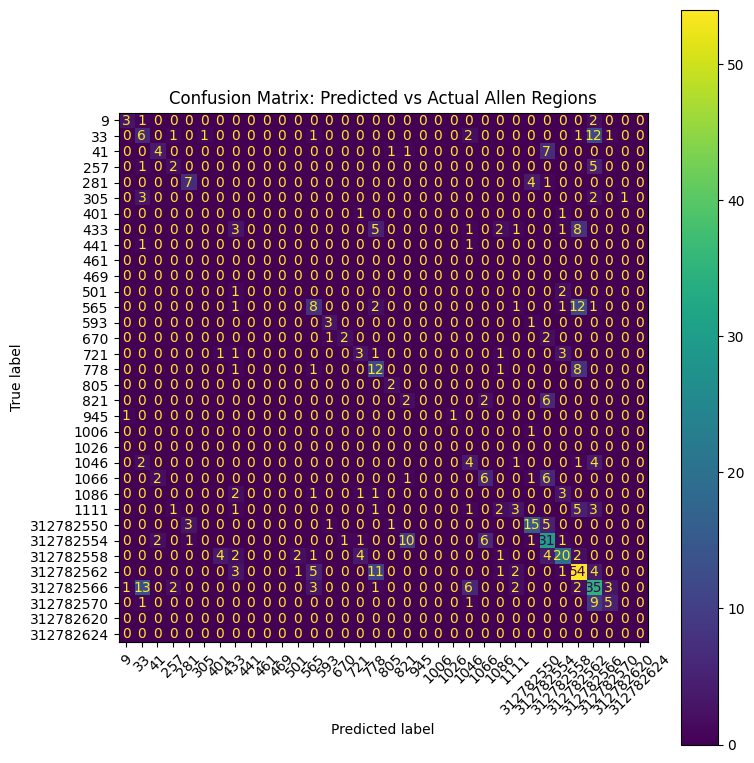

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming:
# y_test_c = true Allen IDs
# y_pred_c = predicted Allen IDs from classifier

cm = confusion_matrix(y_test_c, y_pred_c, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix: Predicted vs Actual Allen Regions')
plt.tight_layout()
plt.show()


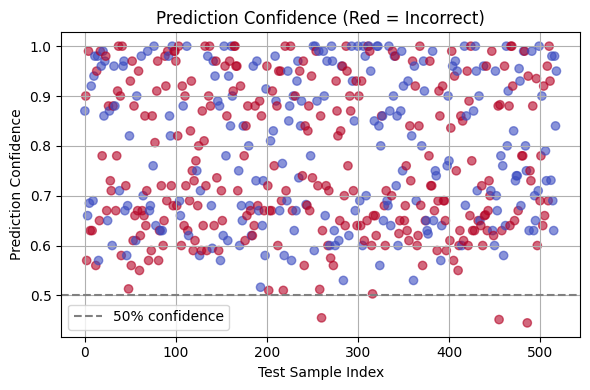

In [149]:
# Get prediction probabilities
probs = clf.predict_proba(X_test_c)
confidence = probs.max(axis=1)  # highest class prob per prediction

# Scatter plot with confidence coloring
plt.figure(figsize=(6, 4))
plt.scatter(range(len(confidence)), confidence, c=(y_pred_c != y_test_c), cmap='coolwarm', alpha=0.6)
plt.axhline(0.5, linestyle='--', color='gray', label='50% confidence')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Confidence')
plt.title('Prediction Confidence (Red = Incorrect)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_153821/2126389374.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='Allen_id', y='Depth', inner='quartile', palette='viridis')


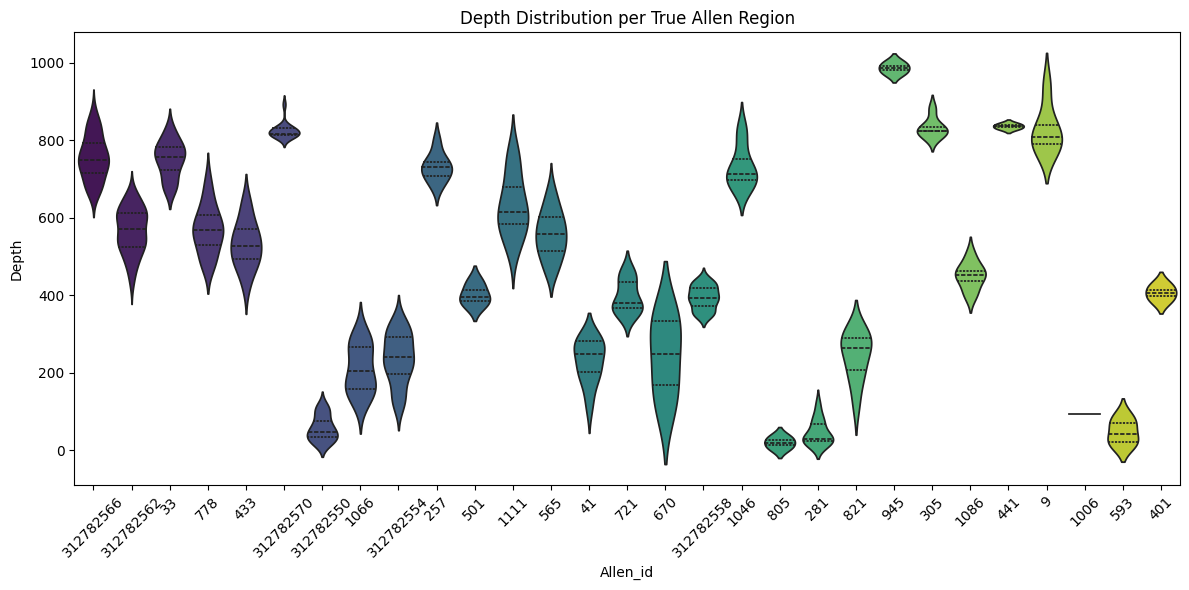

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Allen_id is categorical for plotting clarity
df_features_rs_isocortex_cosmos['Allen_id'] = df_features_rs_isocortex_cosmos['Allen_id'].astype(str)

# Extract test set depths and true labels
depths_test = df_features_rs_isocortex_cosmos.loc[y_test_c.index, 'depths']
true_labels = y_test_c.astype(str)  # convert to string labels if necessary

# Combine into one DataFrame for plotting
import pandas as pd
plot_df = pd.DataFrame({
    'Allen_id': true_labels,
    'Depth': depths_test
})

plt.figure(figsize=(12, 6))
sns.violinplot(data=plot_df, x='Allen_id', y='Depth', inner='quartile', palette='viridis')
plt.xticks(rotation=45)
plt.title('Depth Distribution per True Allen Region')
plt.tight_layout()
plt.show()


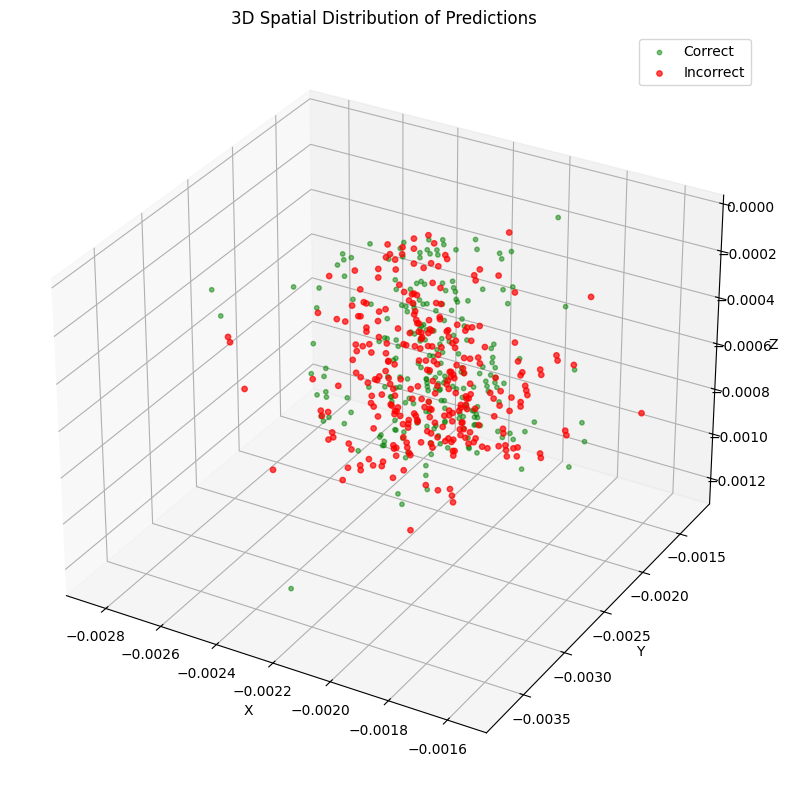

In [151]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Match data from test set
test_idx = y_test_c.index
X_test_xyz = df_features_rs_isocortex_cosmos.loc[test_idx, ['x', 'y', 'z']]
true_labels = y_test_c
pred_labels = pd.Series(y_pred_c, index=test_idx)

# Correct vs incorrect mask
correct_mask = (true_labels == pred_labels)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot correct predictions
ax.scatter(
    X_test_xyz[correct_mask]['x'],
    X_test_xyz[correct_mask]['y'],
    X_test_xyz[correct_mask]['z'],
    c='green', label='Correct', alpha=0.5, s=10
)

# Plot incorrect predictions
ax.scatter(
    X_test_xyz[~correct_mask]['x'],
    X_test_xyz[~correct_mask]['y'],
    X_test_xyz[~correct_mask]['z'],
    c='red', label='Incorrect', alpha=0.7, s=15
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Spatial Distribution of Predictions')
ax.legend()
plt.tight_layout()
plt.show()


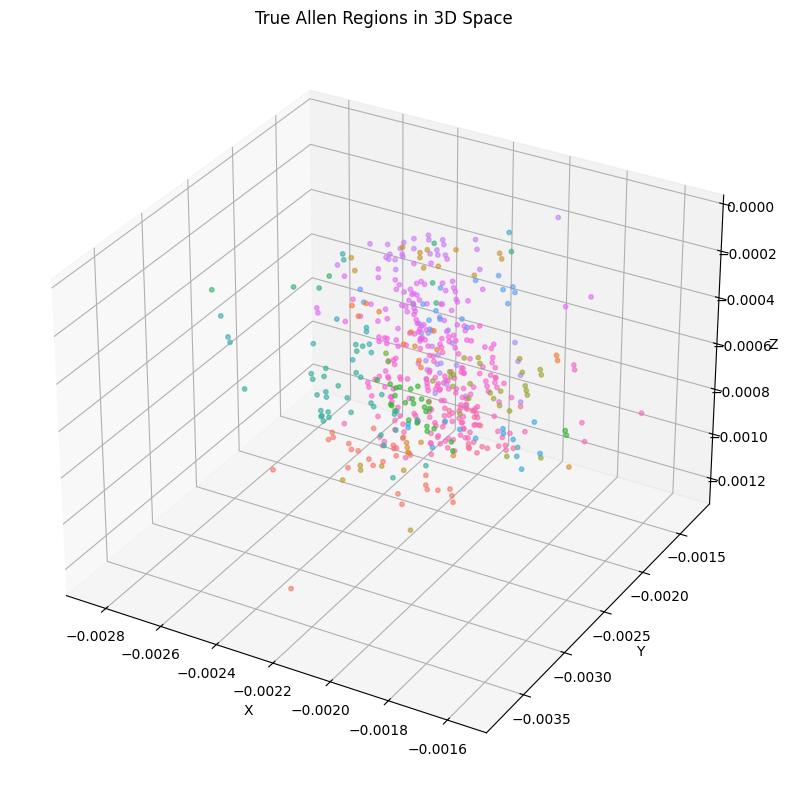

In [152]:
import seaborn as sns

# Assign a unique color to each Allen region
unique_labels = sorted(true_labels.unique())
palette = sns.color_palette("husl", len(unique_labels))
label_to_color = {label: palette[i] for i, label in enumerate(unique_labels)}
colors = true_labels.map(label_to_color)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_test_xyz['x'], X_test_xyz['y'], X_test_xyz['z'],
    c=colors, alpha=0.6, s=10
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('True Allen Regions in 3D Space')
plt.tight_layout()
plt.show()


NOW TRYING DF_FEATURES FOR ALL THE PIDS WITHOUT ONLY BEING THE RS

In [180]:
df_features = df_features.reset_index() 
df_features

level_0   index                                   pid  channel  \
0             0       0  00a824c0-e060-495f-9ebc-79c82fef4c67        0   
1             1       1  00a824c0-e060-495f-9ebc-79c82fef4c67        1   
2             2       2  00a824c0-e060-495f-9ebc-79c82fef4c67        2   
3             3       3  00a824c0-e060-495f-9ebc-79c82fef4c67        3   
4             4       4  00a824c0-e060-495f-9ebc-79c82fef4c67        4   
...         ...     ...                                   ...      ...   
384210   384210  384210  ffb1b072-2de7-44a4-8115-5799b9866382      379   
384211   384211  384211  ffb1b072-2de7-44a4-8115-5799b9866382      380   
384212   384212  384212  ffb1b072-2de7-44a4-8115-5799b9866382      381   
384213   384213  384213  ffb1b072-2de7-44a4-8115-5799b9866382      382   
384214   384214  384214  ffb1b072-2de7-44a4-8115-5799b9866382      383   

          rms_ap  cor_ratio    rms_lf   psd_delta   psd_theta   psd_alpha  \
0       0.000026   0.754190  0.000029 -101.787283 -104.159496 -105.973834   
1       0.000026   0.411007  0.000030 -101.573927 -104.459178 -106.397486   
2       0.000026   0.451987  0.000031 -101.712161 -104.223009 -106.204256   
3       0.000026   0.469155  0.000041  -97.225263 -102.353363 -104.408635   
4       0.000026   0.338838  0.000033  -99.494953 -104.781015 -106.740744   
...          ...        ...       ...         ...         ...         ...   
384210  0.000038   0.788894  0.000045  -96.893853 -101.622061 -104.861699   
384211  0.000038   0.766668  0.000047  -96.756403 -101.407902 -104.768071   
384212  0.000038   0.744558  0.000046  -97.154323 -101.746486 -104.903059   
384213  0.000038   0.696702  0.000048  -96.286040 -101.416863 -104.826851   
384214  0.000038   0.695542  0.000046  -97.056808 -101.644340 -105.094410   

        ...  lateral_um  x_target  y_target  z_target  atlas_id_target  \
0       ...        43.0 -0.000352 -0.002844 -0.003299              795   
1       ...        11.0 -0.000352 -0.002844 -0.003299              795   
2       ...        59.0 -0.000357 -0.002844 -0.003279              795   
3       ...        27.0 -0.000357 -0.002844 -0.003279              795   
4       ...        43.0 -0.000362 -0.002844 -0.003260              795   
...     ...         ...       ...       ...       ...              ...   
384210  ...        27.0  0.001347 -0.006209 -0.003445              512   
384211  ...        43.0  0.001350 -0.006209 -0.003426              512   
384212  ...        11.0  0.001350 -0.006209 -0.003426              512   
384213  ...        59.0  0.001353 -0.006209 -0.003406              512   
384214  ...        27.0  0.001353 -0.006209 -0.003406              512   

        labels  outside  Allen_id  Cosmos_id  Beryl_id  
0          2.0    False       128        313       128  
1          0.0    False       128        313       128  
2          0.0    False       128        313       128  
3          0.0    False       128        313       128  
4          0.0    False       128        313       128  
...        ...      ...       ...        ...       ...  
384210     0.0    False      1025        512      1025  
384211     0.0    False      1025        512      1025  
384212     0.0    False      1025        512      1025  
384213     0.0    False      1025        512      1025  
384214     0.0    False      1025        512      1025  

[384215 rows x 50 columns]

In [181]:
df_features_isocortex_cosmos = df_features[df_features['Cosmos_id'] == 315] 
df_features_isocortex_cosmos = df_features_isocortex_cosmos.reset_index(drop=True) 
df_features_isocortex_cosmos

level_0   index                                   pid  channel  \
0          204     204  00a824c0-e060-495f-9ebc-79c82fef4c67      204   
1          205     205  00a824c0-e060-495f-9ebc-79c82fef4c67      205   
2          206     206  00a824c0-e060-495f-9ebc-79c82fef4c67      206   
3          207     207  00a824c0-e060-495f-9ebc-79c82fef4c67      207   
4          208     208  00a824c0-e060-495f-9ebc-79c82fef4c67      208   
...        ...     ...                                   ...      ...   
63324   383826  383826  ff5fceaf-8247-42ab-a187-f7876441899d      379   
63325   383827  383827  ff5fceaf-8247-42ab-a187-f7876441899d      380   
63326   383828  383828  ff5fceaf-8247-42ab-a187-f7876441899d      381   
63327   383829  383829  ff5fceaf-8247-42ab-a187-f7876441899d      382   
63328   383830  383830  ff5fceaf-8247-42ab-a187-f7876441899d      383   

         rms_ap  cor_ratio    rms_lf  psd_delta  psd_theta  psd_alpha  ...  \
0      0.000015   0.324627  0.000102 -90.667452 -93.052874 -95.462705  ...   
1      0.000015   0.223870  0.000089 -93.064040 -94.215528 -96.759077  ...   
2      0.000015   0.215327  0.000101 -90.226035 -92.361590 -96.223040  ...   
3      0.000015   0.315951  0.000091 -92.343828 -94.833368 -97.613534  ...   
4      0.000015   0.255338  0.000090 -92.409478 -94.012445 -96.401540  ...   
...         ...        ...       ...        ...        ...        ...  ...   
63324  0.000019   0.292517  0.000161 -84.312174 -89.606102 -94.125836  ...   
63325  0.000019   0.279717  0.000162 -84.222207 -89.908032 -94.704802  ...   
63326  0.000019   0.308452  0.000162 -84.223564 -89.877630 -94.478351  ...   
63327  0.000019   0.296210  0.000159 -84.318868 -90.165487 -95.044300  ...   
63328  0.000019   0.270866  0.000159 -84.290076 -90.009341 -94.670658  ...   

       lateral_um  x_target  y_target  z_target  atlas_id_target  labels  \
0            43.0 -0.000857 -0.002844 -0.001322              590     0.0   
1            11.0 -0.000857 -0.002844 -0.001322              590     0.0   
2            59.0 -0.000862 -0.002844 -0.001303              590     0.0   
3            27.0 -0.000862 -0.002844 -0.001303              590     0.0   
4            43.0 -0.000867 -0.002844 -0.001283              590     0.0   
...           ...       ...       ...       ...              ...     ...   
63324        27.0 -0.001650  0.003174 -0.001768              962     0.0   
63325        43.0 -0.001650  0.003174 -0.001768              962     0.0   
63326        11.0 -0.001650  0.003174 -0.001768              962     0.0   
63327        59.0 -0.001650  0.003174 -0.001768              962     0.0   
63328        27.0 -0.001650  0.003174 -0.001768              962     0.0   

       outside  Allen_id  Cosmos_id  Beryl_id  
0        False       542        315       886  
1        False       542        315       886  
2        False       542        315       886  
3        False       542        315       886  
4        False       542        315       886  
...        ...       ...        ...       ...  
63324    False       667        315       184  
63325    False       667        315       184  
63326    False       667        315       184  
63327    False       667        315       184  
63328    False       667        315       184  

[63329 rows x 50 columns]

In [182]:
# Collect the xyz coordinates into a full 2D array
xyz = df_features_isocortex_cosmos[['x', 'y', 'z']].to_numpy()

# Pass the entire array to xyz_to_depth
depths = xyz_to_depth(xyz)

# Assign the result back to the DataFrame
df_features_isocortex_cosmos['depths'] = depths

In [183]:
df_features_isocortex_cosmos['depths_norm'] = (
    df_features_isocortex_cosmos['depths'] - df_features_isocortex_cosmos['depths'].min()
) / (
    df_features_isocortex_cosmos['depths'].max() - df_features_isocortex_cosmos['depths'].min()
)

df_features_isocortex_cosmos = df_features_isocortex_cosmos.dropna(subset=['depths'])
df_features_isocortex_cosmos = df_features_isocortex_cosmos.reset_index(drop=True)
df_features_isocortex_cosmos


level_0   index                                   pid  channel  \
0          204     204  00a824c0-e060-495f-9ebc-79c82fef4c67      204   
1          206     206  00a824c0-e060-495f-9ebc-79c82fef4c67      206   
2          208     208  00a824c0-e060-495f-9ebc-79c82fef4c67      208   
3          210     210  00a824c0-e060-495f-9ebc-79c82fef4c67      210   
4          214     214  00a824c0-e060-495f-9ebc-79c82fef4c67      214   
...        ...     ...                                   ...      ...   
26012   383819  383819  ff5fceaf-8247-42ab-a187-f7876441899d      372   
26013   383821  383821  ff5fceaf-8247-42ab-a187-f7876441899d      374   
26014   383823  383823  ff5fceaf-8247-42ab-a187-f7876441899d      376   
26015   383827  383827  ff5fceaf-8247-42ab-a187-f7876441899d      380   
26016   383829  383829  ff5fceaf-8247-42ab-a187-f7876441899d      382   

         rms_ap  cor_ratio    rms_lf  psd_delta  psd_theta  psd_alpha  ...  \
0      0.000015   0.324627  0.000102 -90.667452 -93.052874 -95.462705  ...   
1      0.000015   0.215327  0.000101 -90.226035 -92.361590 -96.223040  ...   
2      0.000015   0.255338  0.000090 -92.409478 -94.012445 -96.401540  ...   
3      0.000016   0.293725  0.000082 -94.353014 -94.002548 -97.106534  ...   
4      0.000016   0.267512  0.000071 -93.990335 -96.277048 -99.074600  ...   
...         ...        ...       ...        ...        ...        ...  ...   
26012  0.000018   0.292604  0.000165 -84.294745 -89.373551 -93.813861  ...   
26013  0.000018   0.290918  0.000163 -84.237516 -89.381776 -93.965764  ...   
26014  0.000019   0.298159  0.000162 -84.196510 -89.541299 -94.022305  ...   
26015  0.000019   0.279717  0.000162 -84.222207 -89.908032 -94.704802  ...   
26016  0.000019   0.296210  0.000159 -84.318868 -90.165487 -95.044300  ...   

       y_target  z_target  atlas_id_target  labels  outside  Allen_id  \
0     -0.002844 -0.001322              590     0.0    False       542   
1     -0.002844 -0.001303              590     0.0    False       542   
2     -0.002844 -0.001283              590     0.0    False       542   
3     -0.002844 -0.001264              590     0.0    False       542   
4     -0.002844 -0.001225              971     0.0    False       430   
...         ...       ...              ...     ...      ...       ...   
26012  0.003174 -0.001768              962     0.0    False       667   
26013  0.003174 -0.001768              962     0.0    False       667   
26014  0.003174 -0.001768              962     0.0    False       667   
26015  0.003174 -0.001768              962     0.0    False       667   
26016  0.003174 -0.001768              962     0.0    False       667   

       Cosmos_id  Beryl_id      depths  depths_norm  
0            315       886   26.096537     0.010887  
1            315       886   41.145805     0.019921  
2            315       886   59.616249     0.031010  
3            315       886   77.612045     0.041813  
4            315       886   92.787430     0.050923  
...          ...       ...         ...          ...  
26012        315       184  280.605469     0.163676  
26013        315       184  279.619629     0.163084  
26014        315       184  269.545959     0.157036  
26015        315       184  264.610657     0.154074  
26016        315       184  251.666443     0.146303  

[26017 rows x 52 columns]

In [190]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#1. Inputs x and target y
X = df_features_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_isocortex_cosmos['depths']

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

R² score: 0.0755
Mean Squared Error: 99476.3355


/tmp/ipykernel_153821/2228531499.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




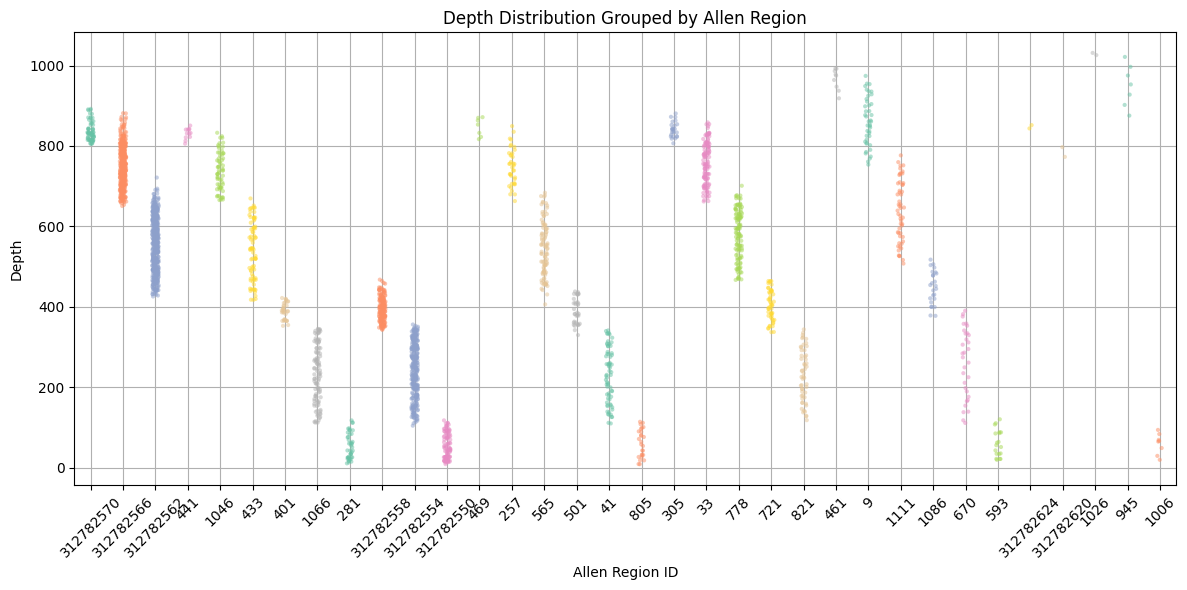

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure Allen_id is categorical (for ordering + aesthetics)
df_features_rs_isocortex_cosmos['Allen_id'] = df_features_rs_isocortex_cosmos['Allen_id'].astype(str)

plt.figure(figsize=(12, 6))
sns.stripplot(
    data=df_features_rs_isocortex_cosmos,
    x='Allen_id',
    y='depths',
    jitter=True,
    alpha=0.5,
    size=3,
    palette='Set2'
)

plt.xticks(rotation=45)
plt.xlabel('Allen Region ID')
plt.ylabel('Depth')
plt.title('Depth Distribution Grouped by Allen Region')
plt.tight_layout()
plt.grid(True)
plt.show()


/tmp/ipykernel_153821/3224856384.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




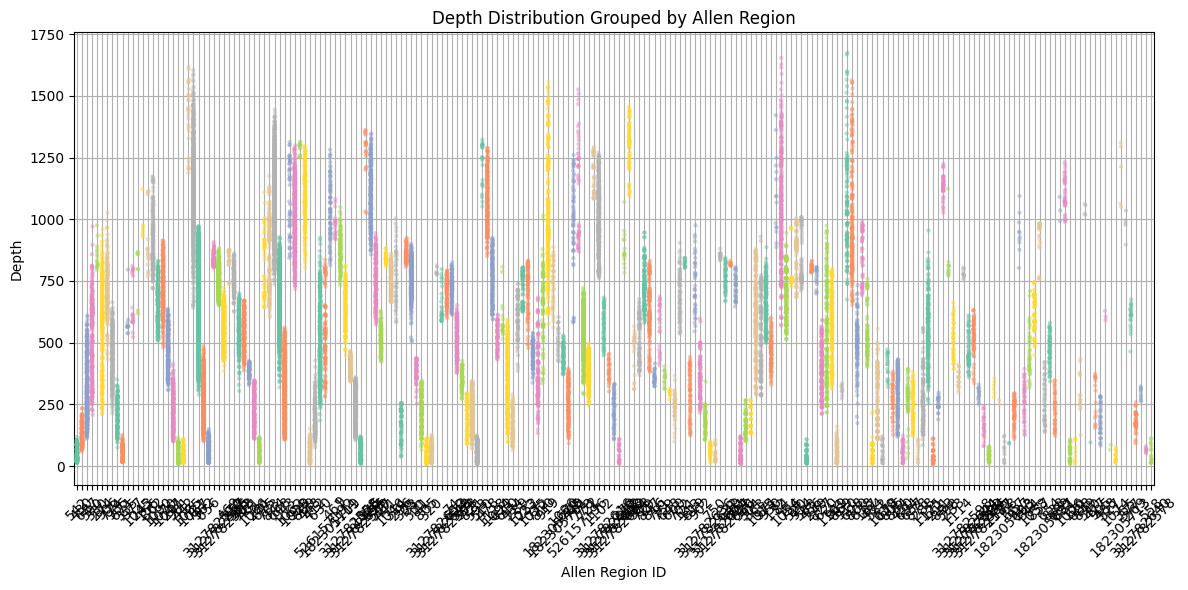

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure Allen_id is categorical (for ordering + aesthetics)
df_features_isocortex_cosmos['Allen_id'] = df_features_isocortex_cosmos['Allen_id'].astype(str)

plt.figure(figsize=(12, 6))
sns.stripplot(
    data=df_features_isocortex_cosmos,
    x='Allen_id',
    y='depths',
    jitter=True,
    alpha=0.5,
    size=3,
    palette='Set2'
)

plt.xticks(rotation=45)
plt.xlabel('Allen Region ID')
plt.ylabel('Depth')
plt.title('Depth Distribution Grouped by Allen Region')
plt.tight_layout()
plt.grid(True)
plt.show()


testing other models

In [196]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#1. Inputs x and target y
X = df_features_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_isocortex_cosmos['depths']

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

R² score: 0.5238
Mean Squared Error: 51237.6552


In [ ]:
#1. Inputs x and target y
X = df_features_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_isocortex_cosmos['depths']

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# 4. Predict on test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R² score: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

R² score: 0.4618
Mean Squared Error: 57912.6703


In [198]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor
)
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# 1. Prepare input
X = df_features_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_isocortex_cosmos['depths']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor()
}

# 4. Fit & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: R² = {r2:.4f}, MSE = {mse:.4f}")


LinearRegression: R² = 0.0755, MSE = 99476.3355
Ridge: R² = 0.0095, MSE = 106577.9201
Lasso: R² = 0.0743, MSE = 99604.0227
ElasticNet: R² = -0.0014, MSE = 107749.0514
BayesianRidge: R² = 0.0755, MSE = 99475.9377
HuberRegressor: R² = 0.0664, MSE = 100454.9769


In [199]:
# Standard imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Data
X = df_features_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_isocortex_cosmos['depths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


🌲 2. Tree-Based Models

In [200]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

tree_models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42)
}

for name, model in tree_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}: R² = {r2_score(y_test, y_pred):.4f}, MSE = {mean_squared_error(y_test, y_pred):.4f}")


DecisionTree: R² = 0.4618, MSE = 57912.6703
RandomForest: R² = 0.9964, MSE = 392.7077
ExtraTrees: R² = 0.9983, MSE = 186.8420


🚀 3. Boosting Frameworks

In [201]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

boost_models = {
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

for name, model in boost_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}: R² = {r2_score(y_test, y_pred):.4f}, MSE = {mean_squared_error(y_test, y_pred):.4f}")


GradientBoosting: R² = 0.7978, MSE = 21753.1972
HistGradientBoosting: R² = 0.9751, MSE = 2678.9342


🧠 4. Support Vector Machines

In [202]:
from sklearn.svm import SVR

svm_models = {
    "SVR (RBF kernel)": SVR(kernel='rbf'),
    "SVR (Linear kernel)": SVR(kernel='linear')
}

for name, model in svm_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}: R² = {r2_score(y_test, y_pred):.4f}, MSE = {mean_squared_error(y_test, y_pred):.4f}")


SVR (RBF kernel): R² = 0.4610, MSE = 57990.9378
SVR (Linear kernel): R² = -0.0000, MSE = 107599.0715


👟 5. Nearest Neighbors

In [203]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print(f"KNN Regressor: R² = {r2_score(y_test, y_pred):.4f}, MSE = {mean_squared_error(y_test, y_pred):.4f}")


KNN Regressor: R² = 0.9955, MSE = 486.1236


🧠 7. Neural Network

In [204]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
print(f"MLPRegressor: R² = {r2_score(y_test, y_pred):.4f}, MSE = {mean_squared_error(y_test, y_pred):.4f}")


MLPRegressor: R² = 0.2154, MSE = 84423.6303


/mnt/h0/kb/code_kcenia/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



ALL MODELS 

In [205]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# -------------------- Data --------------------
X = df_features_isocortex_cosmos[['x', 'y', 'z']]
y = df_features_isocortex_cosmos['depths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------- Models --------------------
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

models = {
    # 1. Linear models
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),

    # 2. Tree-based models
    "DecisionTree": DecisionTreeRegressor(max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42),

    # 3. Boosting
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100),
    "HistGradientBoosting": HistGradientBoostingRegressor(),

    # 4. SVM
    "SVR (RBF kernel)": SVR(kernel='rbf'),
    "SVR (Linear kernel)": SVR(kernel='linear'),

    # 5. KNN
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),

    # 6. Gaussian Process
    "GaussianProcess": GaussianProcessRegressor(),

    # 7. Neural Network
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)
}

# -------------------- Benchmark Loop --------------------
results = []

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        results.append({"Model": name, "R² Score": r2, "MSE": mse})
    except Exception as e:
        results.append({"Model": name, "R² Score": None, "MSE": None})
        print(f"⚠️ {name} failed: {e}")

# -------------------- Results Table --------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R² Score", ascending=False).reset_index(drop=True)

import ace_tools as tools; tools.display_dataframe_to_user(name="Regression Model Benchmark", dataframe=results_df)


/mnt/h0/kb/code_kcenia/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



ModuleNotFoundError: No module named 'ace_tools'